<a href="https://colab.research.google.com/github/mateosuster/nlpPapers/blob/main/10_LDA_TopicModels_GENSIM_EVOLUCION_ANUAL_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencias

In [1]:
%%capture
!pip install pyLDAvis==2.1.2

import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
from collections import Counter


from nltk import word_tokenize, sent_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

import gensim
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from gensim import corpora

import pyLDAvis.gensim
pyLDAvis.enable_notebook()

import os, re, operator, warnings
warnings.filterwarnings('ignore')  
%matplotlib inline

# **LDA: MODEL 1:** ***19 Topics***

In [2]:
### LDA TOPICS:
# params
Tipo_Datos_ = "sampleados"  ### INGRESE DATOS A UTILIZAR: ELIJA: "totales" O "sampleados".
Cant_Optima_Topics = 19     ### INGRESE CANT. OPTIMA DE TOPICOS. 

# data
from pandas.core.describe import describe_categorical_1d
data_Total = pd.read_csv("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/ACL_data.csv")
data_Sampleada = pd.read_csv("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/data_clean.csv")
data_Total_con_Gender_Year = pd.read_csv("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/data_gender_abstract_year.csv")

if Tipo_Datos_ == "sampleados":
  data = data_Sampleada
elif Tipo_Datos_ == "totales":
  data = data_Total

if Tipo_Datos_ == "sampleados":
  dataset = data.text.tolist()
elif Tipo_Datos_ == "totales":
  dataset = data.ABSTRACT
  dataset = dataset.tolist()

#cleaning
STOP_WORDS = stopwords.words("english")

def tokenize(x):
    return [word for word in word_tokenize(x) if word not in STOP_WORDS and word.isalpha() and len(word)>1]

if Tipo_Datos_ == "sampleados":
  texts = [word_tokenize(str(doc)) for doc in dataset]
elif Tipo_Datos_ == "totales":
  texts= [tokenize(str(doc).lower()) for doc in dataset]

#dictionaries
dictionary = corpora.Dictionary(texts)  #crea diccionario asinandole un indice numerico a cada palabra
dictionary.filter_extremes(no_below=10, no_above=0.5)  #filtra tokens q aparencen en menos de 10 documentos y en mas de la mitad de los documentos.

### doc2bow:
corpus = [dictionary.doc2bow(text) for text in texts] #el bow cuenta cantidad de apariciones de cada palabra del diccionario

#### SETEO DE SEMILLA:
semilla = 420
np.random.seed(semilla)

# LDA realizado con el doc2bow (bolsa de palabras comun)  (NO con TF-IDF):
ldamodel_optimo = LdaModel(corpus=corpus, num_topics=Cant_Optima_Topics, id2word=dictionary, iterations = 200, passes=10, random_state=semilla)

#### COHERENCIAS TOTALES DEL MODELO:
window_size_=10     # INGRESE COHERENCIA WINDOW_SIZE 
coherence_='c_npmi' # INGRESE METRICA DE COHERENCIA 
topn_=30            # INGRESE COHERENCIA TOP WORDS TO EVALUATE. 

ldatopics_optimo = [[word for word, prob in topic] for topicid, topic in ldamodel_optimo.show_topics(Cant_Optima_Topics,formatted=False)]
lda_coherence = CoherenceModel(topics=ldatopics_optimo, texts=texts, dictionary=dictionary, window_size=window_size_,coherence=coherence_,topn=topn_).get_coherence_per_topic()
df_lda = pd.DataFrame([range(Cant_Optima_Topics),lda_coherence,ldatopics_optimo],index=['topic_id','coherence','topic']).transpose()

Coherence_Total = (sum(lda_coherence))
Coherence_Media = (np.mean(lda_coherence))
Coherence_Media_Ponderada = Coherence_Media/ Coherence_Total 

print('Nro. Topics Optimo: %.2f ' % (Cant_Optima_Topics))
print('Coherencia Media: %.2f ' % (round(Coherence_Total,2)))
print('Coherencia Total: %.2f ' % (round(Coherence_Media,2)))
print('Coherencia Media Pond: %.2f ' % (round(Coherence_Media_Ponderada,2)))
print(" ")

### GRAFICO DE TOPICOS DEL MODELO:
pyLDAvis.gensim.prepare(ldamodel_optimo, corpus, dictionary)

Nro. Topics Optimo: 19.00 
Coherencia Media: 0.58 
Coherencia Total: 0.03 
Coherencia Media Pond: 0.05 
 


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13    -0.205725  0.099690       1        1  17.862162
17    -0.195022  0.000107       2        1  15.122317
16    -0.163657 -0.079835       3        1  12.129839
15     0.244805  0.004678       4        1   9.261810
4     -0.139230 -0.150102       5        1   9.259746
11    -0.164434  0.040577       6        1   7.195030
3     -0.157124  0.188953       7        1   6.282932
6     -0.067904  0.013775       8        1   3.690298
14    -0.088089 -0.119282       9        1   3.295644
12    -0.012921 -0.278894      10        1   2.622385
18    -0.040398 -0.082796      11        1   2.580502
5     -0.038138  0.191217      12        1   2.480974
1     -0.037517 -0.032840      13        1   2.272601
8     -0.030373  0.175361      14        1   1.982182
9      0.168276 -0.051410      15        1   1.239134
0      0.167785 -0.021096      16        1   1.098521
10     0.216347 -0.013501      17        1   0.752683
2      0.280999  0.079691      18        1   0.459493
7      0.262321  0.035707      19        1   0.411747, topic_info=               Term          Freq         Total Category  logprob  loglift
65      translation   7227.000000   7227.000000  Default  30.0000  30.0000
1113             de  10027.000000  10027.000000  Default  29.0000  29.0000
670           model  11968.000000  11968.000000  Default  28.0000  28.0000
404            task   9108.000000   9108.000000  Default  27.0000  27.0000
702       knowledge   4203.000000   4203.000000  Default  26.0000  26.0000
...             ...           ...           ...      ...      ...      ...
5795       gradient    102.842730    138.391992  Topic19  -4.0232   5.1956
1504          modes     46.736033     56.048048  Topic19  -4.8119   5.3108
5836  terminologies     41.208441     45.843657  Topic19  -4.9378   5.3859
2785  substantially     56.055695    284.227940  Topic19  -4.6301   3.8691
2059       concerns     47.885813    155.810720  Topic19  -4.7876   4.3127

[1130 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
5959      3  0.995420     ablation
7671      9  0.992406         absa
7675      9  0.996221  abstractive
6428     16  0.991589     abundant
7574     11  0.993057      abusive
...     ...       ...          ...
282      13  0.011151         work
282      14  0.010036         work
5711      9  0.985096      workers
3101      5  0.988246     workflow
3640      3  0.996272          wsd

[2641 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 18, 17, 16, 5, 12, 4, 7, 15, 13, 19, 6, 2, 9, 10, 1, 11, 3, 8])

In [ ]:
df_lda.sort_values(by='topic_id',ascending=True)

,topic_id,coherence,topic
0,0,-0.148805,"[errors, error, ranking, clustering, policy, r..."
1,1,0.016376,"[evaluation, human, metrics, visual, automatic..."
2,2,-0.151697,"[bert, transformer, code, ensemble, plms, tran..."
3,3,0.040538,"[model, generation, propose, neural, attention..."
4,4,0.064545,"[language, languages, data, research, paper, n..."
5,5,0.102876,"[knowledge, graph, information, relation, rela..."
6,6,0.140314,"[translation, machine, system, mt, nmt, system..."
7,7,-0.381523,"[platforms, factual, keywords, privacy, subwor..."
8,8,0.17957,"[question, questions, answering, qa, answer, r..."
9,9,-0.015638,"[social, media, response, latent, dialog, heal..."


# **LDA: MODEL 2:** ***32 Topics***

In [3]:
##### LDA TOPICS:
### params
Tipo_Datos_ = "sampleados"  ### INGRESE DATOS A UTILIZAR: ELIJA: "totales" O "sampleados".
Cant_Optima_Topics = 32    #50 #40 #33 ##32     ### INGRESE CANT. OPTIMA DE TOPICOS. 

### DATA
from pandas.core.describe import describe_categorical_1d
data_Total = pd.read_csv("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/ACL_data.csv")
data_Sampleada = pd.read_csv("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/data_clean.csv")
data_Total_con_Gender_Year = pd.read_csv("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/data_gender_abstract_year.csv")
#Table_Topics_32_Tags = pd.read_excel("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/TOPICS_32_TAGS_v2.xlsx")
Table_Topics_32_Tags = pd.read_excel("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/TOPICS_32_TAGS_v3.xlsx")


if Tipo_Datos_ == "sampleados":
  data = data_Sampleada
elif Tipo_Datos_ == "totales":
  data = data_Total

if Tipo_Datos_ == "sampleados":
  dataset = data.text.tolist()
elif Tipo_Datos_ == "totales":
  dataset = data.ABSTRACT
  dataset = dataset.tolist()

#cleaning
STOP_WORDS = stopwords.words("english")

def tokenize(x):
    return [word for word in word_tokenize(x) if word not in STOP_WORDS and word.isalpha() and len(word)>1]

if Tipo_Datos_ == "sampleados":
  texts = [word_tokenize(str(doc)) for doc in dataset]
elif Tipo_Datos_ == "totales":
  texts= [tokenize(str(doc).lower()) for doc in dataset]

#dictionaries
dictionary = corpora.Dictionary(texts)  #crea diccionario asinandole un indice numerico a cada palabra
dictionary.filter_extremes(no_below=10, no_above=0.5)  #filtra tokens q aparencen en menos de 10 documentos y en mas de la mitad de los documentos.

### doc2bow:
corpus = [dictionary.doc2bow(text) for text in texts] #el bow cuenta cantidad de apariciones de cada palabra del diccionario

#### SETEO DE SEMILLA:
semilla = 420  #666 #777 #421 ##420
np.random.seed(semilla)

# LDA realizado con el doc2bow (bolsa de palabras comun)  (NO con TF-IDF):
ldamodel_optimo2 = LdaModel(corpus=corpus, num_topics=Cant_Optima_Topics, id2word=dictionary, iterations = 200, passes=10, random_state=semilla)

#### COHERENCIAS TOTALES DEL MODELO:
window_size_=10     # INGRESE COHERENCIA WINDOW_SIZE 
coherence_='c_npmi' # INGRESE METRICA DE COHERENCIA 
topn_=30            # INGRESE COHERENCIA TOP WORDS TO EVALUATE. 

ldatopics_optimo2 = [[word for word, prob in topic] for topicid, topic in ldamodel_optimo2.show_topics(Cant_Optima_Topics,formatted=False)]
lda_coherence2 = CoherenceModel(topics=ldatopics_optimo2, texts=texts, dictionary=dictionary, window_size=window_size_,coherence=coherence_,topn=topn_).get_coherence_per_topic()
df_lda2 = pd.DataFrame([range(Cant_Optima_Topics),lda_coherence2,ldatopics_optimo2],index=['topic_id','coherence','topic']).transpose()

Coherence_Total = (sum(lda_coherence2))
Coherence_Media = (np.mean(lda_coherence2))
Coherence_Media_Ponderada = Coherence_Media/ Coherence_Total 

print('Nro. Topics Optimo: %.2f ' % (Cant_Optima_Topics))
print('Coherencia Media: %.2f ' % (round(Coherence_Total,2)))
print('Coherencia Media Pond: %.2f ' % (round(Coherence_Media,2)))
#print('Coherencia Media Pond: %.2f ' % (round(Coherence_Media_Ponderada,2)))
print(" ")

### GRAFICO DE TOPICOS DEL MODELO:
pyLDAvis.gensim.prepare(ldamodel_optimo2, corpus, dictionary)

Nro. Topics Optimo: 32.00 
Coherencia Media: -0.02 
Coherencia Media Pond: -0.00 
 


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
17     0.176912  0.115111       1        1  9.351489
15    -0.207492 -0.006783       2        1  9.036965
29     0.201501 -0.086549       3        1  7.997336
20     0.180145  0.004071       4        1  7.818262
25     0.164386 -0.083401       5        1  7.070129
13     0.214642 -0.064365       6        1  6.280664
19     0.162781 -0.005540       7        1  5.423939
4      0.120960  0.131348       8        1  5.228357
16     0.121610  0.131783       9        1  4.875336
30     0.162526 -0.052624      10        1  4.755652
27     0.153449 -0.119290      11        1  4.054587
5      0.049945  0.209005      12        1  3.066422
21     0.089281  0.078932      13        1  2.708469
26     0.079373 -0.138604      14        1  2.334189
24     0.009102  0.084561      15        1  1.962732
23     0.072481 -0.110650      16        1  1.962337
22     0.031309  0.043607      17        1  1.937191
11     0.060463 -0.126592      18        1  1.838958
1      0.015115 -0.086898      19        1  1.631943
28     0.056773 -0.062891      20        1  1.599749
6     -0.029232 -0.032578      21        1  1.488142
12    -0.063657  0.244235      22        1  1.241115
18    -0.090664  0.217297      23        1  1.172528
10    -0.157866  0.045629      24        1  1.050900
14    -0.126995  0.011919      25        1  0.955871
8     -0.166798 -0.053992      26        1  0.849130
3     -0.151477 -0.003908      27        1  0.712357
0     -0.215391 -0.068009      28        1  0.458168
9     -0.220393 -0.067244      29        1  0.449681
2     -0.235980 -0.056300      30        1  0.270903
7     -0.233135 -0.051502      31        1  0.243050
31    -0.223670 -0.039778      32        1  0.173450, topic_info=             Term          Freq         Total Category  logprob  loglift
65    translation   7926.000000   7926.000000  Default  30.0000  30.0000
1113           de  10204.000000  10204.000000  Default  29.0000  29.0000
152          word   4799.000000   4799.000000  Default  28.0000  28.0000
670         model  11201.000000  11201.000000  Default  27.0000  27.0000
762        models  10038.000000  10038.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
780       turning     15.530544     16.482542  Topic32  -5.0491   6.2975
5566    pertinent     13.444215     14.396212  Topic32  -5.1934   6.2886
6090       tasked     12.883037     13.835034  Topic32  -5.2360   6.2857
4736      adapter     65.800311     99.126752  Topic32  -3.6053   5.9473
6238       chance     27.407891     55.636499  Topic32  -4.4811   5.6490

[1811 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
3844     17  0.993592  abilities
5959      3  0.994193   ablation
7671     10  0.992796       absa
3429      9  0.348556   absolute
3429     14  0.649365   absolute
...     ...       ...        ...
3640     19  0.992518        wsd
7830     31  0.983995    xgboost
2284      8  0.228628       year
2284     11  0.769422       year
3794     22  0.991054       zero

[4486 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 16, 30, 21, 26, 14, 20, 5, 17, 31, 28, 6, 22, 27, 25, 24, 23, 12, 2, 29, 7, 13, 19, 11, 15, 9, 4, 1, 10, 3, 8, 32])

### ***Analisis Cualitativo de Tópicos:***
#### ***Topicos n=32***
##### Cuadrante I 

**Frances** <br>
3 Papers en frances <br>
19 Papers en frances + ruido <br>
<br>


##### Cuadrante II

**Modelos del lenguaje**

1 Language Models <br>
2 Language Models - Embeddings, commonsense <br>
6 Clasification tasks? <br>

18 seq2seq <br>
14 Multilingual Neural Machine Translation (NMT) <br>
21  Adversarial contrastive learning + kg <br>
<br>

##### Cuadrante III
**Sentiments** <br>
20 Sentimental analysis <br>
23 Analysis de tweets (hater speach) <br> <br>

**Transformers** <br>
22 Transformes + social media <br> <br>

26 Pos tagging <br> <br>

25 eventos temporales <br>
24 Dialogue response

32 SVM / Ensambles <br>
27 arabic segmentation <br>
31 Universal Dependencies (UD) <br>

29 Ruido / Out-of-Domain(OOD)

<br> <br>
##### Cuadrante IV
**Semantics / Embedings** <br>
4 Multimodal <br>
5 World similarity / Analisis Semántico <br>
8 Sumarization <br>
11 Machine Translation <br> <br>

7 NLP community advances ? <br>
9 Modelos multilingual / BERT <br>
10 Systems learning tasks? <br> <br>
 
14 automatic speach recognition (asr) <br> 
16  a knowledge graph (KG) <br>
17 analisis sintactico del discurso <br> <br>

13 Anotacion de corpus <br>
12 Procesamiento historias clinicas / biomedicas





In [ ]:
df_lda2.sort_values(by='topic_id',ascending=True)
"""
topic_id	coherence	topic
0	0	-0.229137	[relations, discourse, relation, claims, units...
1	1	-0.428925	[simplification, readers, ud, patients, misogy...
2	2	0.073514	[languages, language, multilingual, tasks, tra...
3	3	0.06152	[dataset, detection, social, news, text, class...
4	4	0.068299	[word, embeddings, words, sentiment, similarit...
5	5	0.045333	[evaluation, human, study, metrics, linguistic...
6	6	-0.003495	[shared, task, tweets, team, offensive, causal...
7	7	0.179499	[question, reasoning, questions, answering, an...
8	8	-0.192432	[transformer, conversations, transformers, ber...
9	9	-0.10631	[events, expressions, temporal, time, platform...
10	10	-0.076344	[knowledge, multimodal, ner, image, commonsens...
11	11	-0.214767	[et, argument, comments, al, arguments, prompt...
12	12	-0.17166	[summarization, summaries, architectures, impl...
13	13	0.073846	[information, extraction, graph, text, documen...
14	14	0.071262	[parsing, dependency, syntactic, semantic, eve...
15	15	0.045787	[corpus, speech, data, corpora, annotated, pap...
16	16	0.345143	[de, la, des, les, et, le, un, une, en, nous]
17	17	0.0431	[dialogue, data, domain, domains, labeled, res...
18	18	0.102047	[translation, machine, mt, parallel, nmt, alig...
19	19	-0.33508	[samples, qualitative, compression, messages, ...
20	20	0.010441	[system, english, paper, evaluation, results, ...
21	21	0.020131	[annotation, media, annotations, data, feedbac...
22	22	0.024803	[task, system, paper, systems, dataset, score,...
23	23	-0.038536	[entity, entities, named, recognition, ensembl...
24	24	-0.312944	[interpretation, japanese, simultaneous, menti...
25	25	0.123969	[language, nlp, research, processing, data, na...
26	26	0.031872	[embedding, inference, approach, labels, algor...
27	27	0.077539	[neural, network, model, state, emotion, deep,...
28	28	0.05527	[model, propose, models, datasets, training, p...
29	29	-0.023111	[downstream, lexical, semantic, encoder, lexic...
30	30	-0.10377	[biomedical, negative, tagging, probing, pos, ...
31	31	0.062788	[models, model, language, learning, performanc..."""

'\ntopic_id\tcoherence\ttopic\n0\t0\t-0.229137\t[relations, discourse, relation, claims, units...\n1\t1\t-0.428925\t[simplification, readers, ud, patients, misogy...\n2\t2\t0.073514\t[languages, language, multilingual, tasks, tra...\n3\t3\t0.06152\t[dataset, detection, social, news, text, class...\n4\t4\t0.068299\t[word, embeddings, words, sentiment, similarit...\n5\t5\t0.045333\t[evaluation, human, study, metrics, linguistic...\n6\t6\t-0.003495\t[shared, task, tweets, team, offensive, causal...\n7\t7\t0.179499\t[question, reasoning, questions, answering, an...\n8\t8\t-0.192432\t[transformer, conversations, transformers, ber...\n9\t9\t-0.10631\t[events, expressions, temporal, time, platform...\n10\t10\t-0.076344\t[knowledge, multimodal, ner, image, commonsens...\n11\t11\t-0.214767\t[et, argument, comments, al, arguments, prompt...\n12\t12\t-0.17166\t[summarization, summaries, architectures, impl...\n13\t13\t0.073846\t[information, extraction, graph, text, documen...\n14\t14\t0.071262\t

In [ ]:
#df_lda2.sort_values(by='topic_id',ascending=True)
df_lda2.sort_values(by='coherence',ascending=False)

,topic_id,coherence,topic
15,15,0.346401,"[de, les, des, la, et, le, un, en, nous, une]"
10,10,0.225416,"[parsing, dependency, syntactic, parser, tree,..."
27,27,0.131058,"[translation, machine, system, mt, nmt, system..."
23,23,0.10523,"[speech, system, recognition, responses, autom..."
6,6,0.09847,"[representations, word, embeddings, bert, atte..."
5,5,0.089133,"[knowledge, semantic, reasoning, relations, gr..."
8,8,0.087611,"[question, questions, answering, qa, answer, a..."
16,16,0.079749,"[annotation, corpus, event, annotated, events,..."
30,30,0.076888,"[task, classification, detection, sentiment, f..."
25,25,0.068199,"[model, neural, propose, models, proposed, tex..."


In [ ]:
df_lda2

,topic_id,coherence,topic
0,0,-0.188413,"[evidence, sarcasm, political, depression, int..."
1,1,0.03138,"[evaluation, human, metrics, inference, benchm..."
2,2,-0.302234,"[transformer, ensemble, amr, st, transformers,..."
3,3,-0.076507,"[generation, explanations, consistency, ii, nl..."
4,4,0.066196,"[language, paper, resources, research, data, t..."
5,5,0.089133,"[knowledge, semantic, reasoning, relations, gr..."
6,6,0.09847,"[representations, word, embeddings, bert, atte..."
7,7,-0.374109,"[leverage, plms, dense, leaderboard, academic,..."
8,8,0.087611,"[question, questions, answering, qa, answer, a..."
9,9,-0.100629,"[multimodal, adversarial, examples, modalities..."


In [ ]:
df_lda2.to_csv('topic32_x.csv')

# **LDA: MODEL 3:** ***16 Topics***

In [4]:
### LDA TOPICS:
# params
Tipo_Datos_ = "sampleados"  ### INGRESE DATOS A UTILIZAR: ELIJA: "totales" O "sampleados".
Cant_Optima_Topics = 16     ### INGRESE CANT. OPTIMA DE TOPICOS. 

# data
from pandas.core.describe import describe_categorical_1d
data_Total = pd.read_csv("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/ACL_data.csv")
data_Sampleada = pd.read_csv("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/data_clean.csv")
data_Total_con_Gender_Year = pd.read_csv("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/data_gender_abstract_year.csv")

if Tipo_Datos_ == "sampleados":
  data = data_Sampleada
elif Tipo_Datos_ == "totales":
  data = data_Total

if Tipo_Datos_ == "sampleados":
  dataset = data.text.tolist()
elif Tipo_Datos_ == "totales":
  dataset = data.ABSTRACT
  dataset = dataset.tolist()

#cleaning
STOP_WORDS = stopwords.words("english")

def tokenize(x):
    return [word for word in word_tokenize(x) if word not in STOP_WORDS and word.isalpha() and len(word)>1]

if Tipo_Datos_ == "sampleados":
  texts = [word_tokenize(str(doc)) for doc in dataset]
elif Tipo_Datos_ == "totales":
  texts= [tokenize(str(doc).lower()) for doc in dataset]

#dictionaries
dictionary = corpora.Dictionary(texts)  #crea diccionario asinandole un indice numerico a cada palabra
dictionary.filter_extremes(no_below=10, no_above=0.5)  #filtra tokens q aparencen en menos de 10 documentos y en mas de la mitad de los documentos.

### doc2bow:
corpus = [dictionary.doc2bow(text) for text in texts] #el bow cuenta cantidad de apariciones de cada palabra del diccionario

#### SETEO DE SEMILLA:
semilla = 420
np.random.seed(semilla)

# LDA realizado con el doc2bow (bolsa de palabras comun)  (NO con TF-IDF):
ldamodel_optimo3 = LdaModel(corpus=corpus, num_topics=Cant_Optima_Topics, id2word=dictionary, iterations = 200, passes=10, random_state=semilla)

#### COHERENCIAS TOTALES DEL MODELO:
window_size_=10     # INGRESE COHERENCIA WINDOW_SIZE 
coherence_='c_npmi' # INGRESE METRICA DE COHERENCIA 
topn_=30            # INGRESE COHERENCIA TOP WORDS TO EVALUATE. 

ldatopics_optimo3 = [[word for word, prob in topic] for topicid, topic in ldamodel_optimo3.show_topics(Cant_Optima_Topics,formatted=False)]
lda_coherence3 = CoherenceModel(topics=ldatopics_optimo3, texts=texts, dictionary=dictionary, window_size=window_size_,coherence=coherence_,topn=topn_).get_coherence_per_topic()
df_lda3 = pd.DataFrame([range(Cant_Optima_Topics),lda_coherence3,ldatopics_optimo3],index=['topic_id','coherence','topic']).transpose()

Coherence_Total = (sum(lda_coherence3))
Coherence_Media = (np.mean(lda_coherence3))
Coherence_Media_Ponderada = Coherence_Media/ Coherence_Total 

print('Nro. Topics Optimo: %.2f ' % (Cant_Optima_Topics))
print('Coherencia Total: %.2f ' % (round(Coherence_Total,2)))
print('Coherencia Media: %.2f ' % (round(Coherence_Media,2)))
#print('Coherencia Media Pond: %.2f ' % (round(Coherence_Media_Ponderada,2)))
print(" ")

### GRAFICO DE TOPICOS DEL MODELO:
pyLDAvis.gensim.prepare(ldamodel_optimo3, corpus, dictionary)

Nro. Topics Optimo: 16.00 
Coherencia Total: 1.16 
Coherencia Media: 0.07 
 


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13    -0.143775  0.013415       1        1  18.634435
6     -0.120575  0.050564       2        1  12.065976
4     -0.092133  0.049218       3        1  11.284704
15     0.335727 -0.066030       4        1   9.285182
3     -0.095257  0.089127       5        1   6.181185
11    -0.108228  0.038019       6        1   6.058618
9     -0.068651 -0.004325       7        1   5.818349
5     -0.083587 -0.096553       8        1   5.736534
0     -0.055767 -0.119011       9        1   5.222791
12    -0.033748 -0.111173      10        1   4.398085
1     -0.111946  0.090521      11        1   4.252151
14    -0.086499  0.019832      12        1   4.169808
8     -0.065594  0.123271      13        1   3.338183
10     0.100160 -0.293132      14        1   2.066753
7      0.280638 -0.034200      15        1   1.009279
2      0.349235  0.250459      16        1   0.477966, topic_info=              Term          Freq         Total Category  logprob  loglift
1113            de  10060.000000  10060.000000  Default  30.0000  30.0000
152           word   5560.000000   5560.000000  Default  29.0000  29.0000
1282        speech   3139.000000   3139.000000  Default  28.0000  28.0000
762         models  10188.000000  10188.000000  Default  27.0000  27.0000
670          model  11061.000000  11061.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
7916  transformers    181.675212    287.301320  Topic16  -3.6034   4.8851
1282        speech    553.086857   3139.188207  Topic16  -2.4901   3.6072
5121        traits     87.316088    161.105966  Topic16  -4.3360   4.7309
7903          bert    198.787893   1150.641800  Topic16  -3.5133   3.5875
1670  architecture    125.103510    939.610237  Topic16  -3.9764   3.3271

[993 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
7671     11  0.985340         absa
7675     11  0.997750  abstractive
6428      9  0.989540     abundant
7574     12  0.995964      abusive
2354      1  0.289948     achieves
...     ...       ...          ...
194       8  0.001626      written
194      10  0.004879      written
194      12  0.126844      written
194      13  0.017888      written
3640     11  0.994284          wsd

[2418 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 7, 5, 16, 4, 12, 10, 6, 1, 13, 2, 15, 9, 11, 8, 3])

In [ ]:
df_lda3.sort_values(by='topic_id',ascending=True)

,topic_id,coherence,topic
0,0,0.081565,"[word, words, embeddings, similarity, bias, le..."
1,1,0.066911,"[evaluation, dataset, human, datasets, metrics..."
2,2,-0.155031,"[transformer, speech, ensemble, plms, hate, le..."
3,3,0.063725,"[system, information, search, documents, retri..."
4,4,0.03491,"[language, data, languages, corpus, speech, pa..."
5,5,0.062608,"[knowledge, semantic, graph, information, rela..."
6,6,0.046328,"[models, model, tasks, propose, learning, perf..."
7,7,-0.002545,"[sentiment, analysis, leverage, semeval, aspec..."
8,8,0.10328,"[question, social, questions, media, answering..."
9,9,0.028549,"[classification, neural, text, learning, featu..."


### ***Analisis Cualitativo de Tópicos:***
#### ***Topicos n=16***
##### Cuadrante I 
**NLP Popurri** <br>
1 Model Dialogue? <br>
2 World similarity / Analisis Semántico <br>
3 Machine Traslation <br>
4 NLP General <br>
5 Speech recognition/Analisis <br>
7 Anotacion de corpus <br>
8 Clasification tasks / NER / Sentimental Analisys <br>
  <br>

##### Cuadrante II
**Basura** <br>
6 Papers extranjeros/Stop Words, basura. <br>
10 Stop Words, basura. <br>

##### Cuadrante III
**Analisis Social, grafos, Embeddings, Transformers** <br>
9 Grafos para NLP  <br>
11 Social Media Analisis <br>
12 Word Embeddings <br>
13 Transformers <br>
14 Summarization? <br>


##### Cuadrante IV
**Cognición y predictibilidad/creación de textos** <br>
15 Creacion/Prediccion de Textos. <br>
16 Ciencias Cognitivas. <br>




# Save models

In [ ]:
# import os
# from google.colab import files
# from gensim.test.utils import datapath

# # Save models to disk.
# temp_file = datapath("/content/lda")
# ldamodel_optimo.save(temp_file)
# ldamodel_optimo2.save(temp_file)
# ldamodel_optimo3.save(temp_file)

# # Dowload models
# path = "/content/"
# dir_list = os.listdir(path)

# for i in dir_list:
#   if 'lsa' in i or 'lda' in i  :
#     print('downloading',' ', str(i))
#     files.download(path + i)


downloading   lda.state


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

downloading   lda


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

downloading   lda.expElogbeta.npy


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

downloading   lda.id2word


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Evolución anual de Tópicos en NLP:**

#### Para un documento en particular:

>



In [5]:
new_text = dataset[0]

# transform held_out_text into the bag-of-words space
bow_vector = dictionary.doc2bow(word_tokenize(new_text))
lda_vector = ldamodel_optimo[bow_vector]
print("Model 1 - 19 Topics:")
print(lda_vector) # imprime las probabilidades de cada topico

# print the document's single most prominent LDA topic (palabras mas frecuentes de topico mas probable )
print(ldamodel_optimo.print_topic(max(lda_vector, key=lambda item: item[1])[0]))
print(" ")
#################

lda_vector2 = ldamodel_optimo2[bow_vector]
print("Model 2 - 32 Topics:")
print(lda_vector2) # imprime las probabilidades de cada topico

# print the document's single most prominent LDA topic (palabras mas frecuentes de topico mas probable )
print(ldamodel_optimo2.print_topic(max(lda_vector2, key=lambda item: item[1])[0]))
print(" ")
###############

lda_vector3 = ldamodel_optimo3[bow_vector]
print("Model 3 - 16 Topics:")
print(lda_vector3) # imprime las probabilidades de cada topico

# print the document's single most prominent LDA topic (palabras mas frecuentes de topico mas probable )
print(ldamodel_optimo3.print_topic(max(lda_vector3, key=lambda item: item[1])[0]))
print(" ")

Model 1 - 19 Topics:
[(1, 0.015876232), (3, 0.026755802), (4, 0.36537087), (5, 0.066500634), (6, 0.09402149), (9, 0.09162241), (14, 0.03963966), (16, 0.1014749), (17, 0.19377276)]
0.045*"language" + 0.020*"languages" + 0.018*"data" + 0.013*"research" + 0.013*"paper" + 0.012*"nlp" + 0.011*"resources" + 0.010*"tools" + 0.009*"processing" + 0.009*"system"
 
Model 2 - 32 Topics:
[(3, 0.03320969), (4, 0.14699614), (16, 0.014043023), (17, 0.2575875), (21, 0.11580061), (22, 0.013483198), (24, 0.035038214), (26, 0.25133076), (27, 0.12573019)]
0.017*"text" + 0.013*"data" + 0.012*"corpus" + 0.012*"language" + 0.011*"research" + 0.010*"bias" + 0.009*"texts" + 0.007*"information" + 0.007*"corpora" + 0.007*"paper"
 
Model 3 - 16 Topics:
[(1, 0.03995509), (3, 0.33761385), (4, 0.1857086), (9, 0.27501202), (12, 0.04423051), (13, 0.11158367)]
0.017*"system" + 0.011*"information" + 0.010*"search" + 0.010*"documents" + 0.009*"retrieval" + 0.009*"users" + 0.008*"user" + 0.008*"clinical" + 0.008*"text" + 0

### Cargo todos los papers; corro el LDA sobre ellos; y aplico el mismo preprocesamiento:


In [6]:
data_Total_ = data_Total_con_Gender_Year  #data_Total  ### SELECCIONAR DATOS TOTALES: CON GENDER YEAR O SIN GENDER YEAR.

papers_text  = [tokenize(str(doc).lower()) for doc in data_Total_.ABSTRACT]  ###***CARGAR EL **"data_gender_abstract_year.csv"**!!!

papers_text_df = pd.DataFrame([' '.join(text) for text in papers_text], columns = ['text']) # XX PARA QUE ES ESE JOIN???

papers_text_df

,text
0,text worlds virtual environments embodied agen...
1,become increasingly important due speed inform...
2,sharing parameters providing shared features d...
3,work describes process creating corpus twitter...
4,solving text classification weakly supervised ...
...,...
31513,automatic paraphrasing system used experiments...
31514,approach study information processing verbal i...
31515,approach problem based stratificational gramma...
31516,examples ambiguous english constructions polis...


In [ ]:
data_Total_

,YEAR,ABSTRACT,AUTHOR,name,last_name,gender_g,gender_ize,gender_jur,gender_final
0,2022,text worlds virtual environments embodied agen...,"Jansen, Peter",Peter,Jansen,male,NaN,male,male
1,2022,become increasingly important due speed inform...,"Garc{\'\i}a-D{\'\i}az, Jos{\'e} and",Jose,az,male,NaN,NaN,male
2,2022,sharing parameters providing shared features d...,"Bhattacharyya, Aanisha",Aanisha,Bhattacharyya,NaN,female,NaN,female
3,2022,work describes process creating corpus twitter...,"Hossain, Alamgir and",Alamgir,Hossain,male,NaN,NaN,male
4,2022,solving text classification weakly supervised ...,"Gokhale, Omkar and",Omkar,Gokhale,NaN,male,NaN,male
...,...,...,...,...,...,...,...,...,...
31513,1991,automatic paraphrasing system used experiments...,"J{\""a}ppinen, Harri and",Harri,ppinen,male,NaN,NaN,male
31514,1991,approach study information processing verbal i...,"Tomita, Masaru and",Masaru,Tomita,male,NaN,male,male
31515,1991,approach problem based stratificational gramma...,"Hasida, Ko{\^\i}ti and",Koiti,Hasida,NaN,NaN,male,male
31516,1991,examples ambiguous english constructions polis...,"Dasigi, Venu",Venu,Dasigi,NaN,male,NaN,male


In [ ]:
data_Total_.gender_final.unique()

array(['male', 'female'], dtype=object)

In [ ]:
papers_text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31518 entries, 0 to 31517
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    31518 non-null  object
dtypes: object(1)
memory usage: 246.4+ KB


In [20]:
######***********######
#### ****LE PASAMOS A LOS DATOS TOTALES LOS MODELOS YA ENTRENADOS (CON SAMPLEO) PARA OBTENER LOS TOPICOS SOBRE TODOS LOS DOCUMENTOS

results1 = []
results2 = []
results3 = []

for text_i in papers_text_df.text:

  # transform held_out_text into the bag-of-words space
  bow_vector = dictionary.doc2bow(word_tokenize(str(text_i)))
  lda_vector_i_1 = ldamodel_optimo[bow_vector]
  lda_vector_i_2 = ldamodel_optimo2[bow_vector]
  lda_vector_i_3 = ldamodel_optimo3[bow_vector]

  # converting to dict
  result1 = dict(lda_vector_i_1)
  results1.append(result1)
  result2 = dict(lda_vector_i_2)
  results2.append(result2)
  result3 = dict(lda_vector_i_3)
  results3.append(result3)

topics_dis1 = pd.DataFrame(results1)
topics_dis1['year'] = data_Total_.YEAR ### XXXXXX ****FIJATE Q VA data_Total!!!!!!!!! XXXXX
topics_dis1 = topics_dis1.melt(id_vars = 'year', var_name='topic', value_name='prob') ###NO ENTIENDO BIEN Q HACE X


#### MODELO 32 TOPICS:
topics_dis2 = pd.DataFrame(results2)
topics_dis2['year'] = data_Total_.YEAR 

topics_dis2['gender'] = data_Total_.gender_final #### xxxxx

#topics_dis2 = topics_dis2.melt(id_vars = 'year', var_name='topic', value_name='prob') 
topics_dis2 = topics_dis2.melt(id_vars = ['year','gender'], var_name='topic', value_name='prob')
#topics_dis2['gender'] = data_Total_.gender_final


topics_dis3 = pd.DataFrame(results3)
topics_dis3['year'] = data_Total_.YEAR 
######***********######

topics_dis3 = topics_dis3.melt(id_vars = 'year', var_name='topic', value_name='prob')

print("Model 1 - 19 Topics")
print(topics_dis1.head())
print(" ")
print("Model 2 - 32 Topics")
print(topics_dis2.head())
print(" ")
print("Model 3 - 16 Topics")
print(topics_dis3.head())
#topics_dis1
topics_dis2
#topics_dis3

Model 1 - 19 Topics
   year topic      prob
0  2022     1  0.029882
1  2022     1  0.022090
2  2022     1  0.045304
3  2022     1       NaN
4  2022     1  0.041684
 
Model 2 - 32 Topics
   year  gender topic      prob
0  2022    male     1  0.029882
1  2022    male     1  0.022089
2  2022  female     1  0.045304
3  2022    male     1       NaN
4  2022    male     1  0.041684
 
Model 3 - 16 Topics
   year topic      prob
0  2022     0  0.016427
1  2022     0       NaN
2  2022     0       NaN
3  2022     0       NaN
4  2022     0  0.085686


,year,gender,topic,prob
0,2022,male,1,0.029882
1,2022,male,1,0.022089
2,2022,female,1,0.045304
3,2022,male,1,NaN
4,2022,male,1,0.041684
...,...,...,...,...
1008571,1991,male,15,NaN
1008572,1991,male,15,0.018390
1008573,1991,male,15,NaN
1008574,1991,male,15,NaN


In [ ]:
topics_dis2 #1012064 rows × 3 columns

,year,topic,prob,gender
0,2022,1,0.029882,male
1,2022,1,0.022088,male
2,2022,1,0.045303,female
3,2022,1,NaN,male
4,2022,1,0.041685,male
...,...,...,...,...
1008571,1991,15,NaN,NaN
1008572,1991,15,0.018407,NaN
1008573,1991,15,NaN,NaN
1008574,1991,15,NaN,NaN


In [ ]:
Table_Topics_32_Tags

,index,topic_id,coherence,topic,tag,Unnamed: 5,Nro_Topic_pyLDAvis
0,0,0,0.178945,"question,questions,answering,answer,qa,answers...",Chat_Bot,NaN,19
1,1,1,0.033400,"evaluation,human,metrics,study,models,work,res...",Model_Evaluation,NaN,3
2,2,2,0.045277,"social,media,detection,errors,error,health,cor...",Social_Media,?,22
3,3,3,0.059193,"speech,arabic,recognition,spoken,automatic,asr...",Speech_Recognition,NaN,27
4,4,4,0.049652,"system,user,users,systems,framework,architectu...",Machine Comprehension,?,14
5,5,5,0.059421,"languages,multilingual,language,data,domain,av...",Multilenguage,PLM,11
6,6,6,-0.020837,"diff,lexique,non,rentes,tude,peut,leur,propos,...",Basura,?,30
7,7,7,0.163702,"translation,machine,mt,system,quality,systems,...",Machine_Translation,NMT,13
8,8,8,0.055724,"texts,text,articles,dataset,features,news,twee...",Corpus,?,15
9,9,9,0.396959,"de,des,la,les,et,un,le,nous,une,en",No_English,(French),6


In [21]:
##### AGREGO TAGS!!!:

#### MODELO 32 TOPICS:
#Table_Topics_32_Tags
#topics_dis2 = topics_dis2.melt(id_vars = 'year', var_name='topic', value_name='prob')


#topics_dis2_tags = pd.merge(topics_dis2, Table_Topics_32_Tags, how="left", on=["topic","topic_id"])
topics_dis2_tags = pd.merge(left=topics_dis2,right=Table_Topics_32_Tags, how='left', left_on='topic', right_on='topic_id')

#topics_dis2["tag"] = ""
#topics_dis2["Nro_Topic_Viz"] = ""
#for i in range(len(topics_dis2["tag"]) -1):
#  for j in range(len(Table_Topics_32_Tags)-1):
#    if topics_dis2.loc[i,["topic"]] == Table_Topics_32_Tags.loc[j,["topic_id"]]:
#      topics_dis2.loc[i,["tag"]] = Table_Topics_32_Tags.loc[j,["tag"]] 
#      topics_dis2.loc[i,["Nro_Topic_Viz"]] = Table_Topics_32_Tags.loc[j,["Nro_Topic_pyLDAvis"]]

topics_dis2 #1012064 rows × 3 columns
topics_dis2_tags

,year,gender,topic_x,prob,index,topic_id,coherence,topic_y,tag,Unnamed: 5,Nro_Topic_pyLDAvis
0,2022,male,1,0.029882,1,1,0.033400,"evaluation,human,metrics,study,models,work,res...",Model_Evaluation,NaN,3
1,2022,male,1,0.022089,1,1,0.033400,"evaluation,human,metrics,study,models,work,res...",Model_Evaluation,NaN,3
2,2022,female,1,0.045304,1,1,0.033400,"evaluation,human,metrics,study,models,work,res...",Model_Evaluation,NaN,3
3,2022,male,1,NaN,1,1,0.033400,"evaluation,human,metrics,study,models,work,res...",Model_Evaluation,NaN,3
4,2022,male,1,0.041684,1,1,0.033400,"evaluation,human,metrics,study,models,work,res...",Model_Evaluation,NaN,3
...,...,...,...,...,...,...,...,...,...,...,...
1008571,1991,male,15,NaN,15,15,0.045146,"dialogue,model,context,propose,task,response,m...",Chat_Bot,?,9
1008572,1991,male,15,0.018390,15,15,0.045146,"dialogue,model,context,propose,task,response,m...",Chat_Bot,?,9
1008573,1991,male,15,NaN,15,15,0.045146,"dialogue,model,context,propose,task,response,m...",Chat_Bot,?,9
1008574,1991,male,15,NaN,15,15,0.045146,"dialogue,model,context,propose,task,response,m...",Chat_Bot,?,9


In [22]:
####### *******GROUPBY!!!!!!*******

topics_dis_agg1 = topics_dis1.groupby(['year', 'topic' ], as_index= False).agg(
    {'prob' : [np.sum, 'mean', 'median', 'std', 'count'] }
     )
topics_dis_agg1.column = ['year', 'topic' , 'prob_sum', 'prob_mean', 'prob_median', 'std', 'count' ]
topics_dis_agg1 = topics_dis_agg1.reset_index()
#######################

#### MODELO 32 TOPICS:

topics_dis_agg2 = topics_dis2_tags.groupby(['year', 'Nro_Topic_pyLDAvis','tag', 'topic_y'], as_index= False).agg(
    {'prob' : [np.sum, 'mean', 'median', 'std', 'count'] }
     )
topics_dis_agg2.column = ['Year', 'Nro_Topic_Viz' , 'Topic_Tag', 'Words', 'prob_sum', 'prob_mean', 'prob_median', 'std', 'count' ]
topics_dis_agg2 = topics_dis_agg2.reset_index()

topics_dis_agg2_t = topics_dis2_tags.groupby(['year','tag', 'topic_y'], as_index= False).agg(
    {'prob' : [np.sum, 'mean', 'median', 'std', 'count'] }
     )
topics_dis_agg2_t.column = ['Year', 'Topic_Tag', 'Words', 'prob_sum', 'prob_mean', 'prob_median', 'std', 'count' ]
topics_dis_agg2_t = topics_dis_agg2_t.reset_index()

###GENDER
topics_dis_agg2_gender = topics_dis2_tags.groupby(['year','Nro_Topic_pyLDAvis','tag','gender'], as_index= False,group_keys=True).agg(
    {'prob' : [np.sum, 'mean', 'median', 'std', 'count'] }
     )
topics_dis_agg2_gender.column = ['year', 'gender','Nro_Topic_Viz' , 'Topic_Tag', 'WOrds','prob_sum', 'prob_mean', 'prob_median', 'std', 'count' ]
topics_dis_agg2_gender = topics_dis_agg2_gender.reset_index()

topics_dis_agg2_t_gender = topics_dis2_tags.groupby(['year','Nro_Topic_pyLDAvis','tag','gender'], as_index= False).agg(
    {'prob' : [np.sum, 'mean', 'median', 'std', 'count'] }
     )
topics_dis_agg2_t_gender.column = ['year', 'gender','Topic_Tag', 'Words','prob_sum', 'prob_mean', 'prob_median', 'std', 'count' ]
topics_dis_agg2_t_gender = topics_dis_agg2_t_gender.reset_index()



####################
topics_dis_agg3 = topics_dis3.groupby(['year', 'topic' ], as_index= False).agg(
    {'prob' : [np.sum, 'mean', 'median', 'std', 'count'] }
     )
topics_dis_agg3.column = ['year', 'topic' , 'prob_sum', 'prob_mean', 'prob_median', 'std', 'count' ]
topics_dis_agg3 = topics_dis_agg3.reset_index()

#print(topics_dis_agg1.columns)
print(topics_dis_agg2.columns)
#print(topics_dis_agg3.columns)
#topics_dis_agg2.columns

MultiIndex([(             'index',       ''),
            (              'year',       ''),
            ('Nro_Topic_pyLDAvis',       ''),
            (               'tag',       ''),
            (           'topic_y',       ''),
            (              'prob',    'sum'),
            (              'prob',   'mean'),
            (              'prob', 'median'),
            (              'prob',    'std'),
            (              'prob',  'count')],
           )


In [10]:
topics_dis_agg2 #960 rows × 7 columns  #960 rows × 10 columns: OK!!!!

index  year Nro_Topic_pyLDAvis                 tag  \
                                                         
0       0  1991                  1       General_Model   
1       1  1991                  2     Neural_Networks   
2       2  1991                  3    Model_Evaluation   
3       3  1991                  4      Language_Model   
4       4  1991                  5     Text_Generation   
..    ...   ...                ...                 ...   
955   955  2022                 28          Multimodal   
956   956  2022                 29  Sentiment_Analisys   
957   957  2022                 30              Basura   
958   958  2022                 31    Spatial_Temporal   
959   959  2022                 32         IT_Security   

                                               topic_y        prob            \
                                                               sum      mean   
0    models,model,data,training,performance,tasks,l...    2.405048  0.133614   
1    model,information,network,neural,features,prop...    1.355102  0.079712   
2    evaluation,human,metrics,study,models,work,res...    0.043103  0.043103   
3    research,language,nlp,processing,paper,tools,a...    1.557349  0.070789   
4    generation,method,text,sentence,sentences,gene...    0.320761  0.064152   
..                                                 ...         ...       ...   
955  multimodal,visual,image,topic,similarity,phras...   31.757490  0.041731   
956  emotion,reading,emotional,emotions,states,comp...   72.120254  0.070293   
957  diff,lexique,non,rentes,tude,peut,leur,propos,...   50.136366  0.050541   
958  temporal,frame,frames,rents,dont,time,spatial,...  173.038734  0.129423   
959  adversarial,robustness,xml,examples,dictionnai...  161.776100  0.106712   

                               
       median       std count  
0    0.099982  0.096565    18  
1    0.073195  0.049521    17  
2    0.043103       NaN     1  
3    0.056293  0.055877    22  
4    0.061479  0.056318     5  
..        ...       ...   ...  
955  0.029439  0.036682   761  
956  0.054469  0.056289  1026  
957  0.037203  0.040064   992  
958  0.090813  0.115210  1337  
959  0.084038  0.082000  1516  

[960 rows x 10 columns]

In [11]:
topics_dis_agg2.columns 

MultiIndex([(             'index',       ''),
            (              'year',       ''),
            ('Nro_Topic_pyLDAvis',       ''),
            (               'tag',       ''),
            (           'topic_y',       ''),
            (              'prob',    'sum'),
            (              'prob',   'mean'),
            (              'prob', 'median'),
            (              'prob',    'std'),
            (              'prob',  'count')],
           )

In [12]:
topics_dis_agg2_t  #960 rows × 9 columns OK!!!

index  year                 tag  \
                                      
0       0  1991          Annotation   
1       1  1991              Basura   
2       2  1991              Basura   
3       3  1991            Chat_Bot   
4       4  1991            Chat_Bot   
..    ...   ...                 ...   
955   955  2022    Spatial_Temporal   
956   956  2022  Speech_Recognition   
957   957  2022       Summarization   
958   958  2022     Text_Generation   
959   959  2022     Word_Embeddings   

                                               topic_y        prob            \
                                                               sum      mean   
0    corpus,annotation,annotated,paper,data,informa...    0.714278  0.079364   
1    diff,lexique,non,rentes,tude,peut,leur,propos,...    0.169680  0.084840   
2    event,algorithm,concepts,events,approach,extra...    4.767808  0.198659   
3    dialogue,model,context,propose,task,response,m...    0.997793  0.332598   
4    question,questions,answering,answer,qa,answers...    0.170238  0.034048   
..                                                 ...         ...       ...   
955  temporal,frame,frames,rents,dont,time,spatial,...  173.038734  0.129423   
956  speech,arabic,recognition,spoken,automatic,asr...   22.060548  0.031292   
957  documents,document,summarization,style,summari...  295.790081  0.155925   
958  generation,method,text,sentence,sentences,gene...  225.745357  0.123628   
959  word,words,embeddings,dictionary,sense,chinese...  221.647928  0.135234   

                               
       median       std count  
0    0.058819  0.061831     9  
1    0.084840  0.099316     2  
2    0.175079  0.122216    24  
3    0.018389  0.547130     3  
4    0.022271  0.024104     5  
..        ...       ...   ...  
955  0.090813  0.115210  1337  
956  0.022312  0.023851   705  
957  0.141510  0.092058  1897  
958  0.108654  0.077928  1826  
959  0.110212  0.100671  1639  

[960 rows x 9 columns]

In [13]:
topics_dis_agg2_gender  #82 rows × 11 columns XXXXX SOLO 82 REGISTROS!!!! XXXX

index  year  gender Nro_Topic_pyLDAvis               tag  \
                                                              
0      0  1991  female                  3  Model_Evaluation   
1      1  1991    male                  3  Model_Evaluation   
2      2  1993  female                  3  Model_Evaluation   
3      3  1993    male                  3  Model_Evaluation   
4      4  1994  female                  3  Model_Evaluation   
5      5  1994    male                  3  Model_Evaluation   
6      6  1995  female                  3  Model_Evaluation   
7      7  1995    male                  3  Model_Evaluation   
8      8  1997  female                  3  Model_Evaluation   
9      9  1997    male                  3  Model_Evaluation   
10    10  1998  female                  3  Model_Evaluation   
11    11  1998    male                  3  Model_Evaluation   
12    12  1999  female                  3  Model_Evaluation   
13    13  1999    male                  3  Model_Evaluation   
14    14  2000  female                  3  Model_Evaluation   
15    15  2000    male                  3  Model_Evaluation   
16    16  2001  female                  3  Model_Evaluation   
17    17  2001    male                  3  Model_Evaluation   
18    18  2002  female                  3  Model_Evaluation   
19    19  2002    male                  3  Model_Evaluation   
20    20  2003  female                  3  Model_Evaluation   
21    21  2003    male                  3  Model_Evaluation   
22    22  2004  female                  3  Model_Evaluation   
23    23  2004    male                  3  Model_Evaluation   
24    24  2005  female                  3  Model_Evaluation   
25    25  2005    male                  3  Model_Evaluation   
26    26  2006  female                  3  Model_Evaluation   
27    27  2006    male                  3  Model_Evaluation   
28    28  2007  female                  3  Model_Evaluation   
29    29  2007    male                  3  Model_Evaluation   
30    30  2008  female                  3  Model_Evaluation   
31    31  2008    male                  3  Model_Evaluation   
32    32  2009  female                  3  Model_Evaluation   
33    33  2009    male                  3  Model_Evaluation   
34    34  2010  female                  3  Model_Evaluation   
35    35  2010    male                  3  Model_Evaluation   
36    36  2011  female                  3  Model_Evaluation   
37    37  2011    male                  3  Model_Evaluation   
38    38  2012  female                  3  Model_Evaluation   
39    39  2012    male                  3  Model_Evaluation   
40    40  2013  female                  3  Model_Evaluation   
41    41  2013    male                  3  Model_Evaluation   
42    42  2014  female                  3  Model_Evaluation   
43    43  2014    male                  3  Model_Evaluation   
44    44  2015  female                  3  Model_Evaluation   
45    45  2015    male                  3  Model_Evaluation   
46    46  2016  female                  3  Model_Evaluation   
47    47  2016    male                  3  Model_Evaluation   
48    48  2017  female                  3  Model_Evaluation   
49    49  2017    male                  3  Model_Evaluation   
50    50  2018  female                  3  Model_Evaluation   
51    51  2018    male                  3  Model_Evaluation   
52    52  2019  female                  3  Model_Evaluation   
53    53  2019    male                  3  Model_Evaluation   
54    54  2020  female                  3  Model_Evaluation   
55    55  2020    male                  3  Model_Evaluation   
56    56  2021  female                  3  Model_Evaluation   
57    57  2021    male                  3  Model_Evaluation   
58    58  2022  female                  3  Model_Evaluation   
59    59  2022    male                  3  Model_Evaluation   

                                              topic_y       prob            \
                  

In [14]:
import pandas as pd


#data = pd.read_excel('C:/Users/mateo/Documents/repos/nlpPapers/code/data/TOPICS_32_TAGS_v3.xlsx')
data = Table_Topics_32_Tags

data_subset= data[["tag", "Nro_Topic_pyLDAvis"]] 

dict_label = {} 
for index, row in data_subset.iterrows():
  dict_label[row["Nro_Topic_pyLDAvis"]] = row["tag"]

dict_label

{19: 'Chat_Bot',
 3: 'Model_Evaluation',
 22: 'Social_Media',
 27: 'Speech_Recognition',
 14: 'Machine Comprehension',
 11: 'Multilenguage',
 30: 'Basura',
 13: 'Machine_Translation',
 15: 'Corpus',
 6: 'No_English',
 26: 'Lexicon',
 18: 'Grammar',
 28: 'Multimodal',
 21: 'Word_Embeddings',
 17: 'Reasoning_Graphs',
 9: 'Chat_Bot',
 1: 'General_Model',
 16: 'Basura',
 4: 'Language_Model',
 5: 'Text_Generation',
 32: 'IT_Security',
 29: 'Sentiment_Analisys',
 10: 'Annotation',
 24: 'Sentiment_Analisys',
 20: 'Semantic',
 25: 'Summarization',
 23: 'NER',
 2: 'Neural_Networks',
 12: 'Multilenguage',
 8: 'NLP_Gral',
 31: 'Spatial_Temporal',
 7: 'Model_Evaluation'}

In [23]:
tags_disponibles = Table_Topics_32_Tags['tag']
tags_disponibles = tags_disponibles.tolist()
tags_disponibles

['Chat_Bot',
 'Model_Evaluation',
 'Social_Media',
 'Speech_Recognition',
 'Machine Comprehension',
 'Multilenguage',
 'Basura',
 'Machine_Translation',
 'Corpus',
 'No_English',
 'Lexicon',
 'Grammar',
 'Multimodal',
 'Word_Embeddings',
 'Reasoning_Graphs',
 'Chat_Bot',
 'General_Model',
 'Basura',
 'Language_Model',
 'Text_Generation',
 'IT_Security',
 'Sentiment_Analisys',
 'Annotation',
 'Sentiment_Analisys',
 'Semantic',
 'Summarization',
 'NER',
 'Neural_Networks',
 'Multilenguage',
 'NLP_Gral',
 'Spatial_Temporal',
 'Model_Evaluation']

In [ ]:
topics_dis_agg2_gender

index  year  gender Nro_Topic_pyLDAvis               tag  \
                                                              
0      0  1991  female                  3  Model_Evaluation   
1      1  1991    male                  3  Model_Evaluation   
2      2  1993  female                  3  Model_Evaluation   
3      3  1993    male                  3  Model_Evaluation   
4      4  1994  female                  3  Model_Evaluation   
5      5  1994    male                  3  Model_Evaluation   
6      6  1995  female                  3  Model_Evaluation   
7      7  1995    male                  3  Model_Evaluation   
8      8  1997  female                  3  Model_Evaluation   
9      9  1997    male                  3  Model_Evaluation   
10    10  1998  female                  3  Model_Evaluation   
11    11  1998    male                  3  Model_Evaluation   
12    12  1999  female                  3  Model_Evaluation   
13    13  1999    male                  3  Model_Evaluation   
14    14  2000  female                  3  Model_Evaluation   
15    15  2000    male                  3  Model_Evaluation   
16    16  2001  female                  3  Model_Evaluation   
17    17  2001    male                  3  Model_Evaluation   
18    18  2002  female                  3  Model_Evaluation   
19    19  2002    male                  3  Model_Evaluation   
20    20  2003  female                  3  Model_Evaluation   
21    21  2003    male                  3  Model_Evaluation   
22    22  2004  female                  3  Model_Evaluation   
23    23  2004    male                  3  Model_Evaluation   
24    24  2005  female                  3  Model_Evaluation   
25    25  2005    male                  3  Model_Evaluation   
26    26  2006  female                  3  Model_Evaluation   
27    27  2006    male                  3  Model_Evaluation   
28    28  2007  female                  3  Model_Evaluation   
29    29  2007    male                  3  Model_Evaluation   
30    30  2008  female                  3  Model_Evaluation   
31    31  2008    male                  3  Model_Evaluation   
32    32  2009  female                  3  Model_Evaluation   
33    33  2009    male                  3  Model_Evaluation   
34    34  2010  female                  3  Model_Evaluation   
35    35  2010    male                  3  Model_Evaluation   
36    36  2011  female                  3  Model_Evaluation   
37    37  2011    male                  3  Model_Evaluation   
38    38  2012  female                  3  Model_Evaluation   
39    39  2012    male                  3  Model_Evaluation   
40    40  2013  female                  3  Model_Evaluation   
41    41  2013    male                  3  Model_Evaluation   
42    42  2014  female                  3  Model_Evaluation   
43    43  2014    male                  3  Model_Evaluation   
44    44  2015  female                  3  Model_Evaluation   
45    45  2015    male                  3  Model_Evaluation   
46    46  2016  female                  3  Model_Evaluation   
47    47  2016    male                  3  Model_Evaluation   
48    48  2017  female                  3  Model_Evaluation   
49    49  2017    male                  3  Model_Evaluation   
50    50  2018  female                  3  Model_Evaluation   
51    51  2018    male                  3  Model_Evaluation   
52    52  2019  female                  3  Model_Evaluation   
53    53  2019    male                  3  Model_Evaluation   
54    54  2020  female                  3  Model_Evaluation   
55    55  2020    male                  3  Model_Evaluation   
56    56  2021  female                  3  Model_Evaluation   
57    57  2021    male                  3  Model_Evaluation   
58    58  2022  female                  3  Model_Evaluation   
59    59  2022    male                  3  Model_Evaluation   

                                              topic_y       prob            \
                  

# **Selección del Modelo (cant. tópicos):**

In [24]:
### SELECCIONE MODELO: COLOQUE NRO DE TOPICS: 19, 32 O 16
Model_Topics = 32   ### SELECCIONE MODELO: COLOQUE NRO DE TOPICS: 19, 32 O 16

# **Visualización de los Tópicos del Modelo seleccionado:**

---



In [17]:
### GRAFICO DE TOPICOS DEL MODELO:
#pyLDAvis.gensim.prepare(ldamodel_optimo2, corpus, dictionary)

if Model_Topics == 19:
  ldamodel_optimo = ldamodel_optimo
elif Model_Topics == 32:
  ldamodel_optimo = ldamodel_optimo2
elif Model_Topics == 16:
  ldamodel_optimo = ldamodel_optimo3

pyLDAvis.gensim.prepare(ldamodel_optimo, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
17     0.176912  0.115111       1        1  9.354039
15    -0.207492 -0.006783       2        1  9.036677
29     0.201501 -0.086549       3        1  7.998146
20     0.180145  0.004071       4        1  7.811968
25     0.164386 -0.083401       5        1  7.069729
13     0.214642 -0.064365       6        1  6.278943
19     0.162781 -0.005540       7        1  5.425865
4      0.120960  0.131348       8        1  5.224768
16     0.121610  0.131783       9        1  4.876911
30     0.162526 -0.052624      10        1  4.757206
27     0.153449 -0.119290      11        1  4.057935
5      0.049945  0.209005      12        1  3.066957
21     0.089281  0.078932      13        1  2.708214
26     0.079373 -0.138604      14        1  2.334324
24     0.009102  0.084561      15        1  1.961975
23     0.072481 -0.110650      16        1  1.961884
22     0.031309  0.043607      17        1  1.936432
11     0.060463 -0.126592      18        1  1.840895
1      0.015115 -0.086898      19        1  1.631084
28     0.056773 -0.062891      20        1  1.599109
6     -0.029232 -0.032578      21        1  1.490000
12    -0.063657  0.244235      22        1  1.242195
18    -0.090664  0.217297      23        1  1.171834
10    -0.157866  0.045629      24        1  1.050536
14    -0.126995  0.011919      25        1  0.956395
8     -0.166798 -0.053992      26        1  0.849148
3     -0.151477 -0.003908      27        1  0.711453
0     -0.215391 -0.068009      28        1  0.458397
9     -0.220393 -0.067244      29        1  0.449491
2     -0.235980 -0.056300      30        1  0.270924
7     -0.233135 -0.051502      31        1  0.243043
31    -0.223670 -0.039778      32        1  0.173522, topic_info=             Term          Freq         Total Category  logprob  loglift
65    translation   7932.000000   7932.000000  Default  30.0000  30.0000
1113           de  10203.000000  10203.000000  Default  29.0000  29.0000
152          word   4800.000000   4800.000000  Default  28.0000  28.0000
670         model  11201.000000  11201.000000  Default  27.0000  27.0000
762        models  10039.000000  10039.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
780       turning     15.537009     16.489001  Topic32  -5.0491   6.2972
5566    pertinent     13.449811     14.401803  Topic32  -5.1934   6.2882
6090       tasked     12.888399     13.840392  Topic32  -5.2360   6.2854
4736      adapter     65.827701     99.153104  Topic32  -3.6053   5.9470
6238       chance     27.419300     55.657588  Topic32  -4.4811   5.6487

[1811 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
3844     17  0.993977  abilities
5959      3  0.994093   ablation
7671     10  0.992475       absa
3429      9  0.348504   absolute
3429     14  0.649268   absolute
...     ...       ...        ...
3640     19  0.993036        wsd
7830     31  0.984024    xgboost
2284      8  0.228519       year
2284     11  0.769055       year
3794     22  0.990200       zero

[4486 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 16, 30, 21, 26, 14, 20, 5, 17, 31, 28, 6, 22, 27, 25, 24, 23, 12, 2, 29, 7, 13, 19, 11, 15, 9, 4, 1, 10, 3, 8, 32])

lambda 
* cercano a 1 muestra las palabras mas probables de cada topico
* cercano a 0 muestra las palabras mas especificas de cada topico (palabras raras, altamente probables en ese topico y poco probables en los otros). Son palabras muy asociados al topico y son palabras poco probables. Serian palabras diferencialmente mas probables para del topico (pueden ser palabras poco proablbes para el topico pq son poco proablabes en si)´


el grafico de la izquierda muestra los topicos distribuidos espacialmente segun si tienen palabras parecidas

# **Gráficos de la Evolución Anual de los Tópicos:**

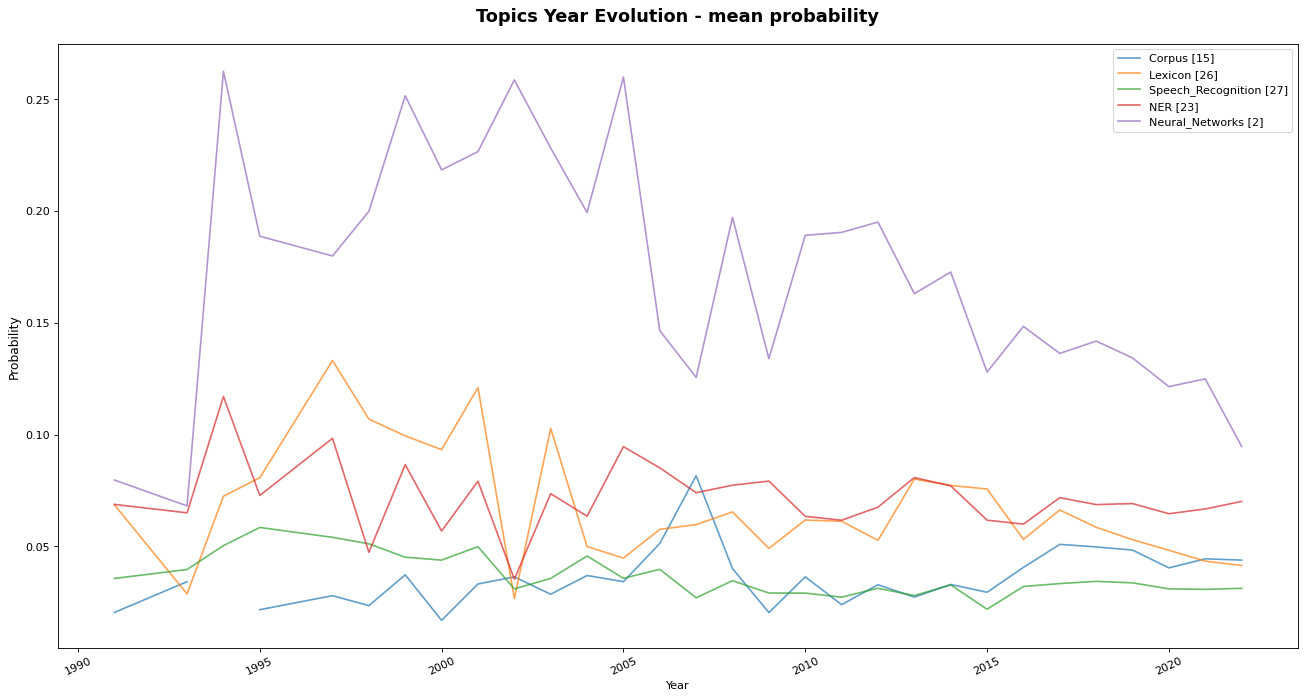

In [18]:
####### GRAFICO EVOLUCION ANUAL TOPICOS:
from matplotlib.pyplot import cm

### SELECCIONE MODELO: COLOQUE NRO DE TOPICS: 19, 32 O 16
#Model_Topics = 32   ### SELECCIONE MODELO: COLOQUE NRO DE TOPICS: 19, 32 O 16

### ACTIVE APERTURA POR GENERO:
Apertura_Genero = False 
Genders = ['male', 'female', 'andy']

### SELECCIONE AGRUPACION TOPICOS: POR NRO TOPICO GRAFICO GENSIM: "number" / POR TAG TOPICO: "tag".
Group_By_Definition = 'number' # 'number' / 'tag' ### SELECCIONE AGRUPACION TOPICOS: POR NRO TOPICO GRAFICO GENSIM: 'number' / POR TAG TOPICO: 'tag'.

viz_all = False  ### True: PARA VER TODOS LOS TOPICS. False: PARA VER SOLO TOPICS SELECCIONADOS (SELECCIONE DEBAJO POR NUMERO O POR TAG).

# SELECCIONE los Nros (del 1 al 32) de los Topicos (segun Grafico Gensim) a visualizar: SOLO DISPONIBLE PARA Group_By_Definition = 'number'
topics2viz = [15, 26, 27, 23, 2]

# SELECCIONE los Nombres (tags) de los Topicos a visualizar: SOLO DISPONIBLE PARA Group_By_Definition = 'tag'
''' NOMBRES (TAGS) DISPONIBLES: 
['Chat_Bot','Model_Evaluation','Social_Media','Speech_Recognition','Machine Comprehension','Multilenguage',
 'Machine_Translation', 'Corpus', 'No_English', 'Lexicon', 'Grammar', 'Multimodal', 'Word_Embeddings', 'Reasoning_Graphs',
 'Chat_Bot', 'General_Model', 'Language_Model', 'Text_Generation', 'IT_Security', 'Sentiment_Analisys', 'Annotation',
 'Sentiment_Analisys', 'Semantic', 'Summarization','NER', 'Neural_Networks', 'Multilenguage', 'NLP_Gral', 'Spatial_Temporal',
 'Model_Evaluation']'''
topics2viz_TAGS = ['Corpus', 'Lexicon', 'Speech_Recognition', 'NER', 'Neural_Networks'] #SELECCIONE NOMBRES (TAGS) DISPONIBLES:

#SELECCIONE metrica: 'sum' 'mean'	'median'	'std'	'count'
metric = 'mean'

#SELECCIONE PALETA DE COLORES:
paleta = 'Dark2' #'gist_rainbow', 'rainbow', 'tab20', 'Set3', 'Set1', 'Dark2'


topics_dis_agg = pd.DataFrame()
if Model_Topics == 19:
  topics_dis_agg = topics_dis_agg1

elif Model_Topics == 32:
  if Apertura_Genero == False: 
    if Group_By_Definition == 'number':
      topics_dis_agg = topics_dis_agg2
    elif Group_By_Definition == 'tag':
      topics_dis_agg = topics_dis_agg2_t
    else:
      print("ERROR: <Group_By_Definition inválido. SELECCIONE: 'number' O 'tag'>")
  else:
    if Group_By_Definition == 'number':
      topics_dis_agg = topics_dis_agg2_gender
    elif Group_By_Definition == 'tag':
      topics_dis_agg = topics_dis_agg2_t_gender
    else:
      print("ERROR: <Group_By_Definition inválido. SELECCIONE: 'number' O 'tag'>")


elif Model_Topics == 16:
  topics_dis_agg = topics_dis_agg3
else:
  print("ERROR: No Disponible Modelo con ese Nro. de Topics. ELIJA ENTRE LOS DISPONIBLES: 19, 32 o 16") 


######### ****GRAFICO:
## General params
fig = plt.figure(figsize=(20, 10), dpi=80)
ax = fig.add_subplot(1, 1, 1)

plt.title("Topics Year Evolution - "+str(metric)+" probability", fontsize=16, fontweight="bold", pad=20)
plt.ylabel("Probability", fontsize=11)
plt.xlabel('Year')
plt.xticks(rotation=25)  # Rotates X-Axis Ticks by 45-degrees

## Color params
NUM_COLORS = Model_Topics
cm = plt.get_cmap(paleta) # ver paletas en https://matplotlib.org/stable/tutorials/colors/colormaps.html
# cm = plt.get_cmap('tab20') 
if paleta != 'tab20' and paleta != 'Set3' and paleta != 'Set1'and paleta != 'Dark2' :
  ax.set_prop_cycle(color=[cm(3.*i/NUM_COLORS) for i in range(NUM_COLORS)])

## Loop    ####### XXXXX ******MODIFICAR: AGREGAR OPCION GROUPBY "TAG"!!!!****(Y AGREGAR PASTE NRO GENSIM PARA GROUPBY "NUMBER")!!!!!!!****** #######
if Apertura_Genero == False:  
  if viz_all == True:
    if Group_By_Definition == 'number':
      #for i in topics_dis_agg.topic.unique():
      for i in topics_dis_agg.Nro_Topic_pyLDAvis.unique():
        #if topics_dis_agg[topics_dis_agg['Nro_Topic_pyLDAvis'] == i]['tag'] != "Basura":
        ax.plot(
            topics_dis_agg[topics_dis_agg["Nro_Topic_pyLDAvis"] == i]["year"],
            topics_dis_agg[topics_dis_agg["Nro_Topic_pyLDAvis"] == i]["prob", metric],
            label = dict_label[i] + ' ' + '[' + str(i) + ']' ,
            alpha=0.7)
        
    elif Group_By_Definition == 'tag':
      for i in topics_dis_agg.tag.unique():
        if i != "Basura":
          ax.plot(
              topics_dis_agg[topics_dis_agg["tag"] == i]["year"],
              topics_dis_agg[topics_dis_agg["tag"] == i]["prob", metric],
              #label = dict_label[i] ,
              label = i,
              alpha=0.7)  
    else:
      print("ERROR: <Group_By_Definition inválido. SELECCIONE: 'number' O 'tag'>") 


  else:
    if Group_By_Definition == 'number': 
      for i in topics2viz:
        ax.plot(
            topics_dis_agg[topics_dis_agg["Nro_Topic_pyLDAvis"] == i]["year"],
            topics_dis_agg[topics_dis_agg["Nro_Topic_pyLDAvis"] == i]["prob", metric],
            label = dict_label[i] + ' ' + '[' + str(i) + ']',
            alpha=0.7)

    elif Group_By_Definition == 'tag':
      for i in topics2viz_TAGS:
        ax.plot(
            topics_dis_agg[topics_dis_agg["tag"] == i]["year"],
              topics_dis_agg[topics_dis_agg["tag"] == i]["prob", metric],
              #label = dict_label[i] ,
              label = i,
              alpha=0.7) 
    else:
      print("ERROR: <Group_By_Definition inválido. SELECCIONE: 'number' O 'tag'>") 

else:
  if viz_all == True:
    if Group_By_Definition == 'number':
      #for i in topics_dis_agg.topic.unique():
      for i in topics_dis_agg.Nro_Topic_pyLDAvis.unique():
        #if topics_dis_agg[topics_dis_agg['Nro_Topic_pyLDAvis'] == i]['tag'] != "Basura":
        for g in Genders:
          ax.plot(
            topics_dis_agg[(topics_dis_agg.Nro_Topic_pyLDAvis == i) & (topics_dis_agg.gender == g)]["year"],
            topics_dis_agg[(topics_dis_agg.Nro_Topic_pyLDAvis == i) & (topics_dis_agg.gender == g)]["prob", metric],
            label = str(dict_label[i]) + ' ' + '[' + str(i) + ']' + ' ' + str(g) ,
            alpha=0.7)
        
    elif Group_By_Definition == 'tag':
      for i in topics_dis_agg.tag.unique():
        for g in Genders:
          if i != "Basura": 
            ax.plot(
              topics_dis_agg[(topics_dis_agg.tag == i) & (topics_dis_agg.gender == g)]["year"],
              topics_dis_agg[(topics_dis_agg.tag == i) & (topics_dis_agg.gender == g)]["prob", metric],
              #label = dict_label[i] ,
              label = i + ' ' + str(g),
              alpha=0.7)  
    else:
      print("ERROR: <Group_By_Definition inválido. SELECCIONE: 'number' O 'tag'>") 


  else:
    if Group_By_Definition == 'number': 
      for i in topics2viz:
        for g in Genders:
          ax.plot(
            topics_dis_agg[(topics_dis_agg.Nro_Topic_pyLDAvis == i) & (topics_dis_agg.gender == g)]["year"],
            topics_dis_agg[(topics_dis_agg.Nro_Topic_pyLDAvis == i) & (topics_dis_agg.gender == g)]["prob", metric],
            label = str(dict_label[i]) + ' ' + '[' + str(i) + ']' + ' ' + str(g) ,
            alpha=0.7)
        
    elif Group_By_Definition == 'tag':
      for i in topics2viz_TAGS:
        for g in Genders:
          if i != "Basura": 
            ax.plot(
              topics_dis_agg[(topics_dis_agg.tag == i) & (topics_dis_agg.gender == g)]["year"],
              topics_dis_agg[(topics_dis_agg.tag == i) & (topics_dis_agg.gender == g)]["prob", metric],
              #label = dict_label[i] ,
              label = i + ' ' + str(g),
              alpha=0.7)           
    else:
      print("ERROR: <Group_By_Definition inválido. SELECCIONE: 'number' O 'tag'>") 


## Eliminacion de legendas duplicadas      
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))
legend_without_duplicate_labels(ax)

## Display
plt.show()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


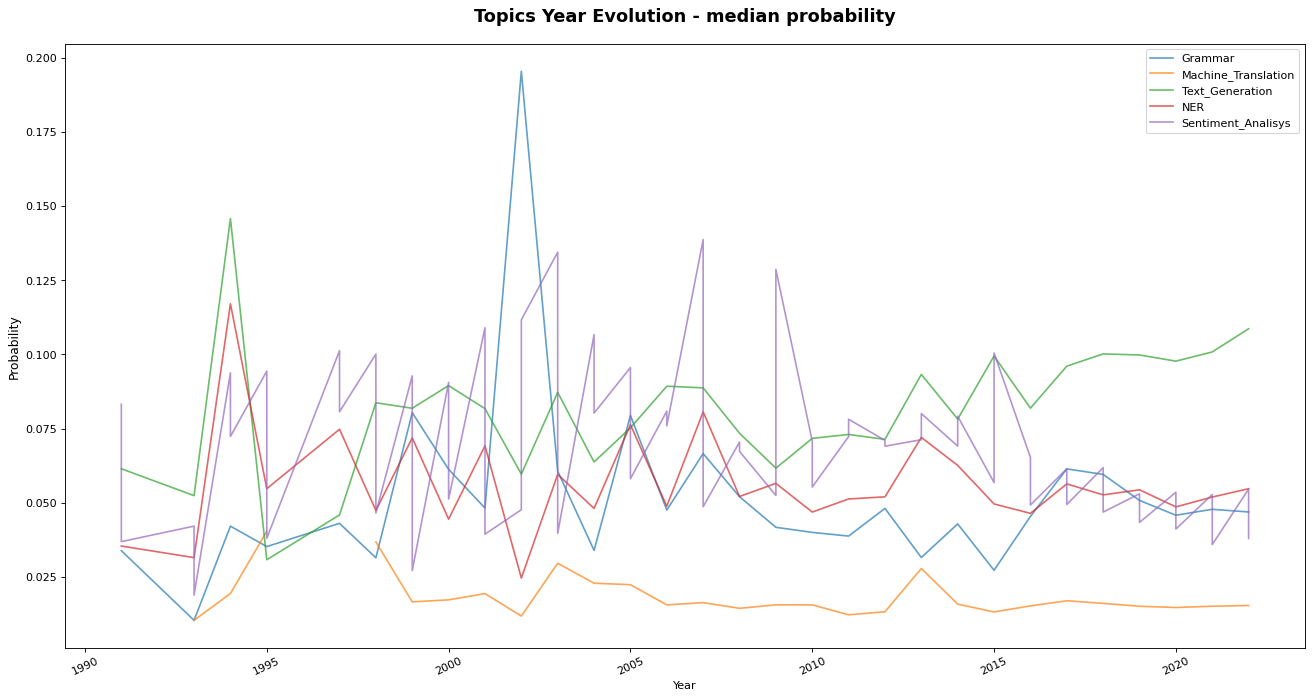

In [ ]:
####### GRAFICO EVOLUCION ANUAL TOPICOS:
from matplotlib.pyplot import cm

### SELECCIONE MODELO: COLOQUE NRO DE TOPICS: 19, 32 O 16
#Model_Topics = 32   ### SELECCIONE MODELO: COLOQUE NRO DE TOPICS: 19, 32 O 16

### ACTIVE APERTURA POR GENERO:
Apertura_Genero = False 
Genders = ['male', 'female','andy']

### SELECCIONE AGRUPACION TOPICOS: POR NRO TOPICO GRAFICO GENSIM: "number" / POR TAG TOPICO: "tag".
Group_By_Definition = 'tag' # 'number' / 'tag' ### SELECCIONE AGRUPACION TOPICOS: POR NRO TOPICO GRAFICO GENSIM: 'number' / POR TAG TOPICO: 'tag'.

viz_all = False  ### True: PARA VER TODOS LOS TOPICS. False: PARA VER SOLO TOPICS SELECCIONADOS (SELECCIONE DEBAJO POR NUMERO O POR TAG).

# SELECCIONE los Nros (del 1 al 32) de los Topicos (segun Grafico Gensim) a visualizar: SOLO DISPONIBLE PARA Group_By_Definition = 'number'
topics2viz = [15, 26, 27, 23, 2]

# SELECCIONE los Nombres (tags) de los Topicos a visualizar: SOLO DISPONIBLE PARA Group_By_Definition = 'tag'
''' NOMBRES (TAGS) DISPONIBLES: 
['Chat_Bot','Model_Evaluation','Social_Media','Speech_Recognition','Machine Comprehension','Multilenguage',
 'Machine_Translation', 'Corpus', 'No_English', 'Lexicon', 'Grammar', 'Multimodal', 'Word_Embeddings', 'Reasoning_Graphs',
 'Chat_Bot', 'General_Model', 'Language_Model', 'Text_Generation', 'IT_Security', 'Sentiment_Analisys', 'Annotation',
 'Sentiment_Analisys', 'Semantic', 'Summarization','NER', 'Neural_Networks', 'Multilenguage', 'NLP_Gral', 'Spatial_Temporal',
 'Model_Evaluation']'''
#topics2viz_TAGS = ['Corpus', 'Lexicon', 'Speech_Recognition', 'NER', 'Neural_Networks'] #SELECCIONE NOMBRES (TAGS) DISPONIBLES:
topics2viz_TAGS = ['Grammar', 'Machine_Translation', 'Text_Generation', 'NER', 'Sentiment_Analisys'] #SELECCIONE NOMBRES (TAGS) DISPONIBLES:


#SELECCIONE metrica: 'sum' 'mean'	'median'	'std'	'count'
metric = 'median' #'mean' ##'sum'

#SELECCIONE PALETA DE COLORES:
paleta = 'Dark2' #'gist_rainbow', 'rainbow', 'tab20', 'Set3', 'Set1', 'Dark2'


topics_dis_agg = pd.DataFrame()
if Model_Topics == 19:
  topics_dis_agg = topics_dis_agg1

elif Model_Topics == 32:
  if Apertura_Genero == False: 
    if Group_By_Definition == 'number':
      topics_dis_agg = topics_dis_agg2
    elif Group_By_Definition == 'tag':
      topics_dis_agg = topics_dis_agg2_t
    else:
      print("ERROR: <Group_By_Definition inválido. SELECCIONE: 'number' O 'tag'>")
  else:
    if Group_By_Definition == 'number':
      topics_dis_agg = topics_dis_agg2_gender
    elif Group_By_Definition == 'tag':
      topics_dis_agg = topics_dis_agg2_t_gender
    else:
      print("ERROR: <Group_By_Definition inválido. SELECCIONE: 'number' O 'tag'>")


elif Model_Topics == 16:
  topics_dis_agg = topics_dis_agg3
else:
  print("ERROR: No Disponible Modelo con ese Nro. de Topics. ELIJA ENTRE LOS DISPONIBLES: 19, 32 o 16") 


######### ****GRAFICO:
#python -m pip install scipy
!pip install scipy
from scipy.optimize import curve_fit

## General params
fig = plt.figure(figsize=(20, 10), dpi=80)
ax = fig.add_subplot(1, 1, 1)

plt.title("Topics Year Evolution - "+str(metric)+" probability", fontsize=16, fontweight="bold", pad=20)
plt.ylabel("Probability", fontsize=11)
plt.xlabel('Year')
plt.xticks(rotation=25)  # Rotates X-Axis Ticks by 45-degrees

## Color params
NUM_COLORS = Model_Topics
cm = plt.get_cmap(paleta) #'gist_rainbow'## ver paletas en https://matplotlib.org/stable/tutorials/colors/colormaps.html
# cm = plt.get_cmap('tab20') 
if paleta != 'tab20' and paleta != 'Set3' and paleta != 'Set1'and paleta != 'Dark2' :
  ax.set_prop_cycle(color=[cm(3.*i/NUM_COLORS) for i in range(NUM_COLORS)])

## Loop    ####### XXXXX ******MODIFICAR: AGREGAR OPCION GROUPBY "TAG"!!!!****(Y AGREGAR PASTE NRO GENSIM PARA GROUPBY "NUMBER")!!!!!!!****** #######
if Apertura_Genero == False:  
  if viz_all == True:
    if Group_By_Definition == 'number':
      #for i in topics_dis_agg.topic.unique():
      for i in topics_dis_agg.Nro_Topic_pyLDAvis.unique():
        #if topics_dis_agg[topics_dis_agg['Nro_Topic_pyLDAvis'] == i]['tag'] != "Basura":
        ax.plot(
            topics_dis_agg[topics_dis_agg["Nro_Topic_pyLDAvis"] == i]["year"],
            topics_dis_agg[topics_dis_agg["Nro_Topic_pyLDAvis"] == i]["prob", metric],
            label = dict_label[i] + ' ' + '[' + str(i) + ']',
            alpha=0.7)
        
    elif Group_By_Definition == 'tag':
      for i in topics_dis_agg.tag.unique():
        if i != "Basura":
          ax.plot( #scipy.optimize.curve_fit(
              topics_dis_agg[topics_dis_agg["tag"] == i]["year"],
              topics_dis_agg[topics_dis_agg["tag"] == i]["prob", metric],
              #label = dict_label[i] ,
              label = i,
              alpha=0.7)  
    else:
      print("ERROR: <Group_By_Definition inválido. SELECCIONE: 'number' O 'tag'>") 


  else:
    if Group_By_Definition == 'number': 
      for i in topics2viz:
        ax.plot(
            topics_dis_agg[topics_dis_agg["Nro_Topic_pyLDAvis"] == i]["year"],
            topics_dis_agg[topics_dis_agg["Nro_Topic_pyLDAvis"] == i]["prob", metric],
            label = dict_label[i] + ' ' + '[' + str(i) + ']',
            alpha=0.7)

    elif Group_By_Definition == 'tag':
      for i in topics2viz_TAGS:
        ax.plot(
            topics_dis_agg[topics_dis_agg["tag"] == i]["year"],
              topics_dis_agg[topics_dis_agg["tag"] == i]["prob", metric],
              #label = dict_label[i] ,
              label = i,
              alpha=0.7) 
    else:
      print("ERROR: <Group_By_Definition inválido. SELECCIONE: 'number' O 'tag'>") 

else:
  if viz_all == True:
    if Group_By_Definition == 'number':
      #for i in topics_dis_agg.topic.unique():
      for i in topics_dis_agg.Nro_Topic_pyLDAvis.unique():
        #if topics_dis_agg[topics_dis_agg['Nro_Topic_pyLDAvis'] == i]['tag'] != "Basura":
        for g in Genders:
          ax.plot(
            topics_dis_agg[(topics_dis_agg.Nro_Topic_pyLDAvis == i) & (topics_dis_agg.gender == g)]["year"],
            topics_dis_agg[(topics_dis_agg.Nro_Topic_pyLDAvis == i) & (topics_dis_agg.gender == g)]["prob", metric],
            label = str(dict_label[i]) + ' ' + '[' + str(i) + ']' + ' ' + str(g) ,
            alpha=0.7)
        
    elif Group_By_Definition == 'tag':
      for i in topics_dis_agg.tag.unique():
        for g in Genders:
          if i != "Basura": 
            ax.plot(
              topics_dis_agg[(topics_dis_agg.tag == i) & (topics_dis_agg.gender == g)]["year"],
              topics_dis_agg[(topics_dis_agg.tag == i) & (topics_dis_agg.gender == g)]["prob", metric],
              #label = dict_label[i] ,
              label = i + ' ' + str(g),
              alpha=0.7)  
    else:
      print("ERROR: <Group_By_Definition inválido. SELECCIONE: 'number' O 'tag'>") 


  else:
    if Group_By_Definition == 'number': 
      for i in topics2viz:
        for g in Genders:
          ax.plot(
            topics_dis_agg[(topics_dis_agg.Nro_Topic_pyLDAvis == i) & (topics_dis_agg.gender == g)]["year"],
            topics_dis_agg[(topics_dis_agg.Nro_Topic_pyLDAvis == i) & (topics_dis_agg.gender == g)]["prob", metric],
            label = str(dict_label[i]) + ' ' + '[' + str(i) + ']'+ ' ' + str(g) ,
            alpha=0.7)
        
    elif Group_By_Definition == 'tag':
      for i in topics2viz_TAGS:
        for g in Genders:
          if i != "Basura": 
            ax.plot(
              topics_dis_agg[(topics_dis_agg.tag == i) & (topics_dis_agg.gender == g)]["year"],
              topics_dis_agg[(topics_dis_agg.tag == i) & (topics_dis_agg.gender == g)]["prob", metric],
              #label = dict_label[i] ,
              label = i + ' ' + str(g),
              alpha=0.7)           
    else:
      print("ERROR: <Group_By_Definition inválido. SELECCIONE: 'number' O 'tag'>") 


## Eliminacion de legendas duplicadas      
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))
legend_without_duplicate_labels(ax)

## Display
plt.show()

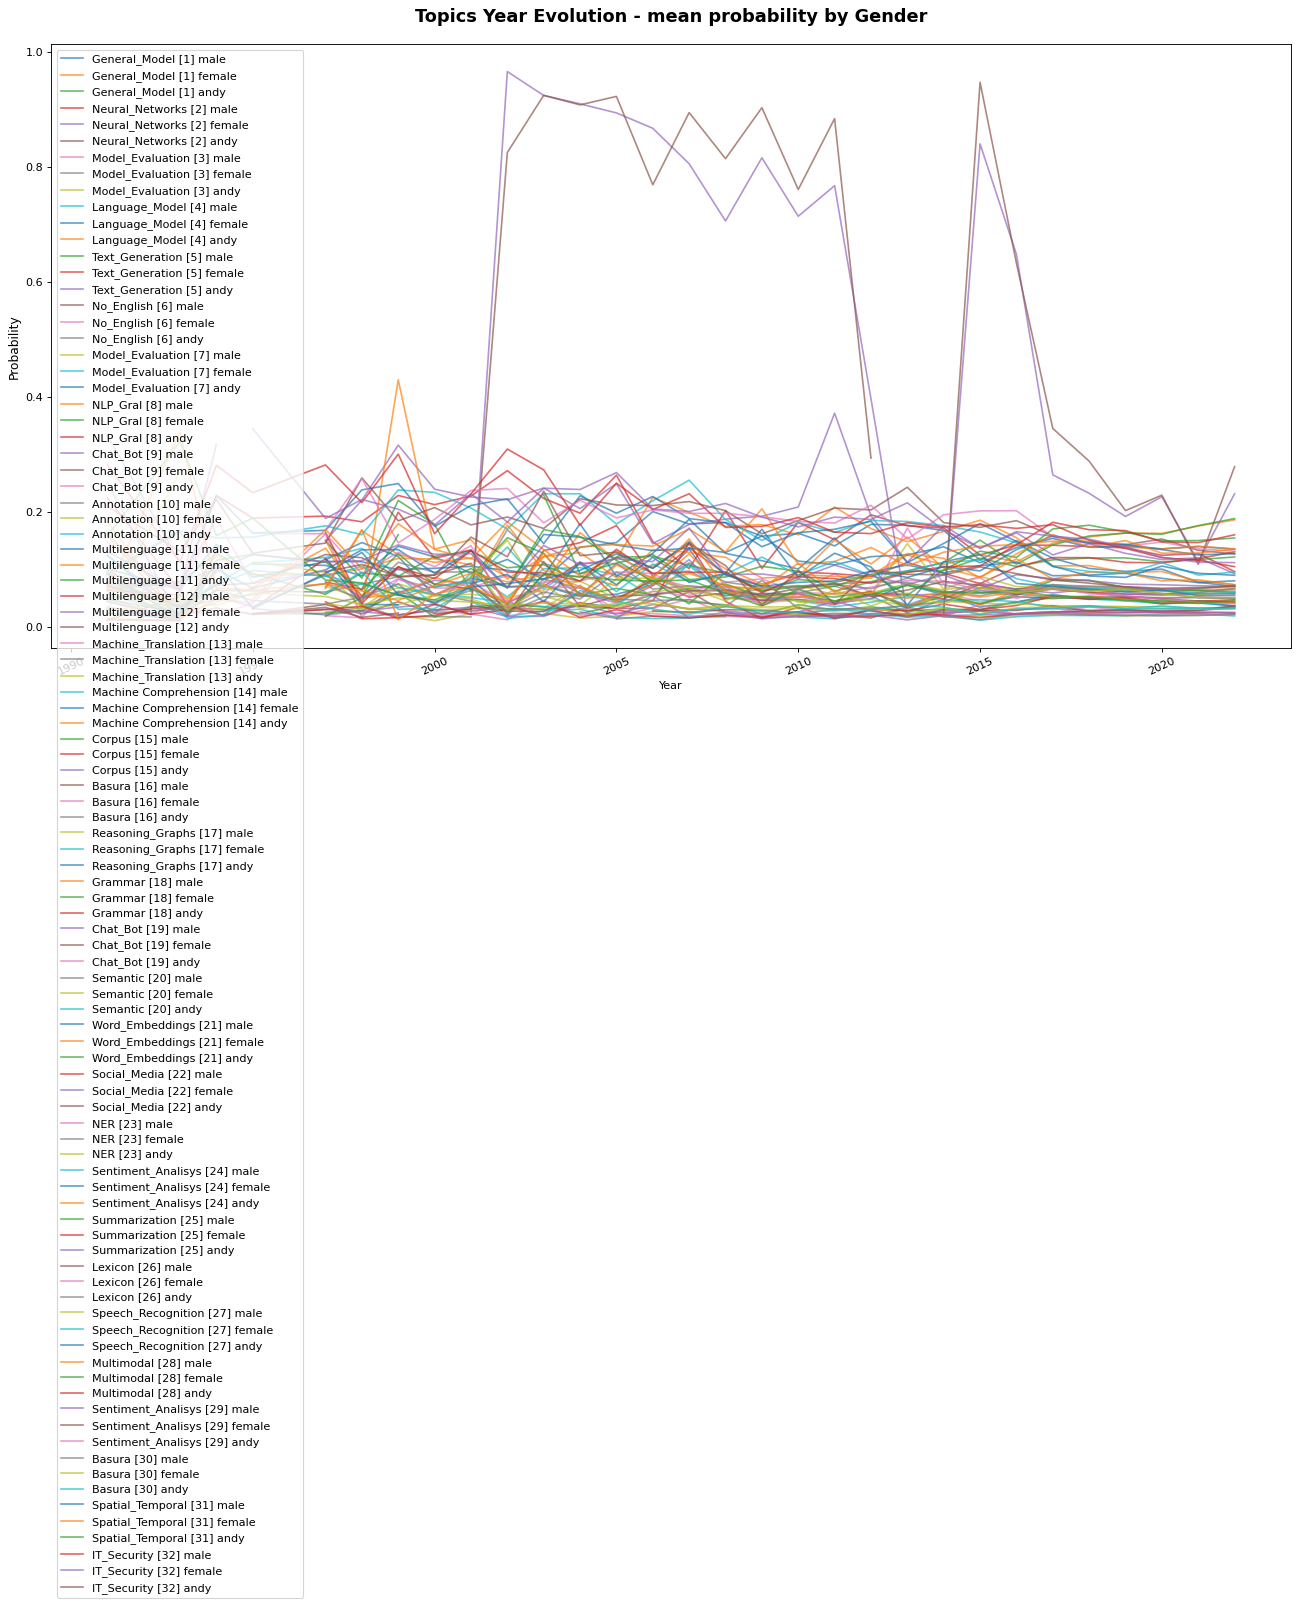

In [25]:
####### GRAFICO EVOLUCION ANUAL TOPICOS:
from matplotlib.pyplot import cm

### SELECCIONE MODELO: COLOQUE NRO DE TOPICS: 19, 32 O 16
#Model_Topics = 32   ### SELECCIONE MODELO: COLOQUE NRO DE TOPICS: 19, 32 O 16

### ACTIVE APERTURA POR GENERO:
Apertura_Genero = True 
Genders = ['male', 'female','andy']

### SELECCIONE AGRUPACION TOPICOS: POR NRO TOPICO GRAFICO GENSIM: "number" / POR TAG TOPICO: "tag".
Group_By_Definition = 'number' # 'number' / 'tag' ### SELECCIONE AGRUPACION TOPICOS: POR NRO TOPICO GRAFICO GENSIM: 'number' / POR TAG TOPICO: 'tag'.

viz_all = True  ### True: PARA VER TODOS LOS TOPICS. False: PARA VER SOLO TOPICS SELECCIONADOS (SELECCIONE DEBAJO POR NUMERO O POR TAG).

# SELECCIONE los Nros (del 1 al 32) de los Topicos (segun Grafico Gensim) a visualizar: SOLO DISPONIBLE PARA Group_By_Definition = 'number'
topics2viz = [15, 26, 27, 23, 2]

# SELECCIONE los Nombres (tags) de los Topicos a visualizar: SOLO DISPONIBLE PARA Group_By_Definition = 'tag'
''' NOMBRES (TAGS) DISPONIBLES: 
['Chat_Bot','Model_Evaluation','Social_Media','Speech_Recognition','Machine Comprehension','Multilenguage',
 'Machine_Translation', 'Corpus', 'No_English', 'Lexicon', 'Grammar', 'Multimodal', 'Word_Embeddings', 'Reasoning_Graphs',
 'Chat_Bot', 'General_Model', 'Language_Model', 'Text_Generation', 'IT_Security', 'Sentiment_Analisys', 'Annotation',
 'Sentiment_Analisys', 'Semantic', 'Summarization','NER', 'Neural_Networks', 'Multilenguage', 'NLP_Gral', 'Spatial_Temporal',
 'Model_Evaluation']'''
topics2viz_TAGS = ['Corpus', 'Lexicon', 'Speech_Recognition', 'NER', 'Neural_Networks'] #SELECCIONE NOMBRES (TAGS) DISPONIBLES:

#SELECCIONE metrica: 'sum' 'mean'	'median'	'std'	'count'
metric = 'mean'

#SELECCIONE PALETA DE COLORES:
paleta = 'Dark2' #'gist_rainbow', 'rainbow', 'tab20', 'Set3', 'Set1', 'Dark2'


topics_dis_agg = pd.DataFrame()
if Model_Topics == 19:
  topics_dis_agg = topics_dis_agg1

elif Model_Topics == 32:
  if Apertura_Genero == False: 
    if Group_By_Definition == 'number':
      topics_dis_agg = topics_dis_agg2
    elif Group_By_Definition == 'tag':
      topics_dis_agg = topics_dis_agg2_t
    else:
      print("ERROR: <Group_By_Definition inválido. SELECCIONE: 'number' O 'tag'>")
  else:
    if Group_By_Definition == 'number':
      topics_dis_agg = topics_dis_agg2_gender
    elif Group_By_Definition == 'tag':
      topics_dis_agg = topics_dis_agg2_t_gender
    else:
      print("ERROR: <Group_By_Definition inválido. SELECCIONE: 'number' O 'tag'>")


elif Model_Topics == 16:
  topics_dis_agg = topics_dis_agg3
else:
  print("ERROR: No Disponible Modelo con ese Nro. de Topics. ELIJA ENTRE LOS DISPONIBLES: 19, 32 o 16") 


######### ****GRAFICO:
## General params
fig = plt.figure(figsize=(20, 10), dpi=80)
ax = fig.add_subplot(1, 1, 1)

plt.title("Topics Year Evolution - "+str(metric)+" probability" + ' by Gender', fontsize=16, fontweight="bold", pad=20)
plt.ylabel("Probability", fontsize=11)
plt.xlabel('Year')
plt.xticks(rotation=25)  # Rotates X-Axis Ticks by 45-degrees

## Color params
NUM_COLORS = Model_Topics
cm = plt.get_cmap(paleta) # ver paletas en https://matplotlib.org/stable/tutorials/colors/colormaps.html
# cm = plt.get_cmap('tab20') 
if paleta != 'tab20' and paleta != 'Set3' and paleta != 'Set1'and paleta != 'Dark2' :
  ax.set_prop_cycle(color=[cm(3.*i/NUM_COLORS) for i in range(NUM_COLORS)])


## Loop    ####### XXXXX ******MODIFICAR: AGREGAR OPCION GROUPBY "TAG"!!!!****(Y AGREGAR PASTE NRO GENSIM PARA GROUPBY "NUMBER")!!!!!!!****** #######
if Apertura_Genero == False:  
  if viz_all == True:
    if Group_By_Definition == 'number':
      #for i in topics_dis_agg.topic.unique():
      for i in topics_dis_agg.Nro_Topic_pyLDAvis.unique():
        #if topics_dis_agg[topics_dis_agg['Nro_Topic_pyLDAvis'] == i]['tag'] != "Basura":
        ax.plot(
            topics_dis_agg[topics_dis_agg["Nro_Topic_pyLDAvis"] == i]["year"],
            topics_dis_agg[topics_dis_agg["Nro_Topic_pyLDAvis"] == i]["prob", metric],
            label = dict_label[i] + ' ' + '[' + str(i) + ']',
            alpha=0.7)
        
    elif Group_By_Definition == 'tag':
      for i in topics_dis_agg.tag.unique():
        if i != "Basura":
          ax.plot(
              topics_dis_agg[topics_dis_agg["tag"] == i]["year"],
              topics_dis_agg[topics_dis_agg["tag"] == i]["prob", metric],
              #label = dict_label[i] ,
              label = i,
              alpha=0.7)  
    else:
      print("ERROR: <Group_By_Definition inválido. SELECCIONE: 'number' O 'tag'>") 


  else:
    if Group_By_Definition == 'number': 
      for i in topics2viz:
        ax.plot(
            topics_dis_agg[topics_dis_agg["Nro_Topic_pyLDAvis"] == i]["year"],
            topics_dis_agg[topics_dis_agg["Nro_Topic_pyLDAvis"] == i]["prob", metric],
            label = dict_label[i] + ' ' + '[' + str(i) + ']',
            alpha=0.7)

    elif Group_By_Definition == 'tag':
      for i in topics2viz_TAGS:
        ax.plot(
            topics_dis_agg[topics_dis_agg["tag"] == i]["year"],
              topics_dis_agg[topics_dis_agg["tag"] == i]["prob", metric],
              #label = dict_label[i] ,
              label = i,
              alpha=0.7) 
    else:
      print("ERROR: <Group_By_Definition inválido. SELECCIONE: 'number' O 'tag'>") 

else:
  if viz_all == True:
    if Group_By_Definition == 'number':
      #for i in topics_dis_agg.topic.unique():
      for i in topics_dis_agg.Nro_Topic_pyLDAvis.unique():
        #if topics_dis_agg[topics_dis_agg['Nro_Topic_pyLDAvis'] == i]['tag'] != "Basura":
        for g in Genders:
          ax.plot(
            topics_dis_agg[(topics_dis_agg.Nro_Topic_pyLDAvis == i) & (topics_dis_agg.gender == g)]["year"],
            topics_dis_agg[(topics_dis_agg.Nro_Topic_pyLDAvis == i) & (topics_dis_agg.gender == g)]["prob", metric],
            label = str(dict_label[i])+ ' ' + '[' + str(i) + ']' + ' ' + str(g) ,
            alpha=0.7)
        
    elif Group_By_Definition == 'tag':
      for i in topics_dis_agg.tag.unique():
        for g in Genders:
          if i != "Basura": 
            ax.plot(
              topics_dis_agg[(topics_dis_agg.tag == i) & (topics_dis_agg.gender == g)]["year"],
              topics_dis_agg[(topics_dis_agg.tag == i) & (topics_dis_agg.gender == g)]["prob", metric],
              #label = dict_label[i] ,
              label = i + ' ' + str(g),
              alpha=0.7)  
    else:
      print("ERROR: <Group_By_Definition inválido. SELECCIONE: 'number' O 'tag'>") 


  else:
    if Group_By_Definition == 'number': 
      for i in topics2viz:
        for g in Genders:
          ax.plot(
            topics_dis_agg[(topics_dis_agg.Nro_Topic_pyLDAvis == i) & (topics_dis_agg.gender == g)]["year"],
            topics_dis_agg[(topics_dis_agg.Nro_Topic_pyLDAvis == i) & (topics_dis_agg.gender == g)]["prob", metric],
            label = str(dict_label[i]) + ' ' + '[' + str(i) + ']'+ ' ' + str(g) ,
            alpha=0.7)
        
    elif Group_By_Definition == 'tag':
      for i in topics2viz_TAGS:
        for g in Genders:
          if i != "Basura": 
            ax.plot(
              topics_dis_agg[(topics_dis_agg.tag == i) & (topics_dis_agg.gender == g)]["year"],
              topics_dis_agg[(topics_dis_agg.tag == i) & (topics_dis_agg.gender == g)]["prob", metric],
              #label = dict_label[i] ,
              label = i + ' ' + str(g),
              alpha=0.7)           
    else:
      print("ERROR: <Group_By_Definition inválido. SELECCIONE: 'number' O 'tag'>") 


## Eliminacion de legendas duplicadas      
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))
legend_without_duplicate_labels(ax)

## Display
plt.show()

In [ ]:
topics_dis_agg.to_csv('topic_distribution_year.csv', index = False)
files.download('/content/topic_distribution_year.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Probabilidad total

In [ ]:
# topic_dis_agg = pd.read_csv('/content/topic_distribution_year.csv')
df_prob_tot = topics_dis2_tags
df_prob_tot
# df_99 = df_prob_tot.loc[:,  [ ('year',''), ('tag',''), ('prob', 'mean')] ]
# df_99.columns = ['year', 'tag', 'prob']

# df_99.groupby('year')['prob'].sum()

,year,topic_x,prob,gender,index,topic_id,coherence,topic_y,tag,Unnamed: 5,Nro_Topic_pyLDAvis
0,2022,1,0.029882,male,1,1,0.033400,"evaluation,human,metrics,study,models,work,res...",Model_Evaluation,NaN,3
1,2022,1,0.022088,male,1,1,0.033400,"evaluation,human,metrics,study,models,work,res...",Model_Evaluation,NaN,3
2,2022,1,0.045303,female,1,1,0.033400,"evaluation,human,metrics,study,models,work,res...",Model_Evaluation,NaN,3
3,2022,1,NaN,male,1,1,0.033400,"evaluation,human,metrics,study,models,work,res...",Model_Evaluation,NaN,3
4,2022,1,0.041685,male,1,1,0.033400,"evaluation,human,metrics,study,models,work,res...",Model_Evaluation,NaN,3
...,...,...,...,...,...,...,...,...,...,...,...
1008571,1991,15,NaN,NaN,15,15,0.045146,"dialogue,model,context,propose,task,response,m...",Chat_Bot,?,9
1008572,1991,15,0.018407,NaN,15,15,0.045146,"dialogue,model,context,propose,task,response,m...",Chat_Bot,?,9
1008573,1991,15,NaN,NaN,15,15,0.045146,"dialogue,model,context,propose,task,response,m...",Chat_Bot,?,9
1008574,1991,15,NaN,NaN,15,15,0.045146,"dialogue,model,context,propose,task,response,m...",Chat_Bot,?,9


In [ ]:
df_prob_tot.groupby('index')['prob'].sum()

index
0      147.357031
1      551.245732
2       89.208581
3      212.186830
4     1423.401062
5      927.933374
6      555.378658
7       71.217426
8      262.265075
9      147.071965
10     328.843236
11     675.656851
12     384.097431
13    2112.489075
14     265.353700
15    1437.467938
16    1343.198364
17    2811.440202
18     360.395593
19    1904.094828
20    2380.303623
21     829.357649
22     623.575538
23     559.459866
24     632.748301
25    2704.126614
26     784.652647
27    1241.078178
28     546.274446
29    3009.933724
30    1785.354604
31      47.168405
Name: prob, dtype: float64

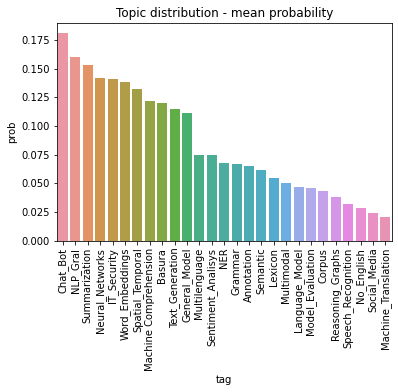

In [ ]:


df_99_agg = df_prob_tot.groupby(['tag'],as_index = False).agg( { 'prob': 'mean'}).sort_values('prob', ascending = False)
df_99_agg.columns = ['tag', 'prob']


# importing the required library
import seaborn as sns
 
 
# who v/s fare barplot
sns.barplot(x = 'tag',
            y = 'prob',
            data = df_99_agg)

plt.xticks(rotation=90)
plt.title("Topic distribution - mean probability")

# Show the plot
plt.show()

In [ ]:
df_99_agg['prob'].sum()

2.311272117236934

In [ ]:
topics_dis_agg

index  year  gender Nro_Topic_pyLDAvis               tag  \
                                                              
0      0  1991  female                  3  Model_Evaluation   
1      1  1991    male                  3  Model_Evaluation   
2      2  1993  female                  3  Model_Evaluation   
3      3  1993    male                  3  Model_Evaluation   
4      4  1994  female                  3  Model_Evaluation   
5      5  1994    male                  3  Model_Evaluation   
6      6  1995  female                  3  Model_Evaluation   
7      7  1995    male                  3  Model_Evaluation   
8      8  1997  female                  3  Model_Evaluation   
9      9  1997    male                  3  Model_Evaluation   
10    10  1998  female                  3  Model_Evaluation   
11    11  1998    male                  3  Model_Evaluation   
12    12  1999  female                  3  Model_Evaluation   
13    13  1999    male                  3  Model_Evaluation   
14    14  2000  female                  3  Model_Evaluation   
15    15  2000    male                  3  Model_Evaluation   
16    16  2001  female                  3  Model_Evaluation   
17    17  2001    male                  3  Model_Evaluation   
18    18  2002  female                  3  Model_Evaluation   
19    19  2002    male                  3  Model_Evaluation   
20    20  2003  female                  3  Model_Evaluation   
21    21  2003    male                  3  Model_Evaluation   
22    22  2004  female                  3  Model_Evaluation   
23    23  2004    male                  3  Model_Evaluation   
24    24  2005  female                  3  Model_Evaluation   
25    25  2005    male                  3  Model_Evaluation   
26    26  2006  female                  3  Model_Evaluation   
27    27  2006    male                  3  Model_Evaluation   
28    28  2007  female                  3  Model_Evaluation   
29    29  2007    male                  3  Model_Evaluation   
30    30  2008  female                  3  Model_Evaluation   
31    31  2008    male                  3  Model_Evaluation   
32    32  2009  female                  3  Model_Evaluation   
33    33  2009    male                  3  Model_Evaluation   
34    34  2010  female                  3  Model_Evaluation   
35    35  2010    male                  3  Model_Evaluation   
36    36  2011  female                  3  Model_Evaluation   
37    37  2011    male                  3  Model_Evaluation   
38    38  2012  female                  3  Model_Evaluation   
39    39  2012    male                  3  Model_Evaluation   
40    40  2013  female                  3  Model_Evaluation   
41    41  2013    male                  3  Model_Evaluation   
42    42  2014  female                  3  Model_Evaluation   
43    43  2014    male                  3  Model_Evaluation   
44    44  2015  female                  3  Model_Evaluation   
45    45  2015    male                  3  Model_Evaluation   
46    46  2016  female                  3  Model_Evaluation   
47    47  2016    male                  3  Model_Evaluation   
48    48  2017  female                  3  Model_Evaluation   
49    49  2017    male                  3  Model_Evaluation   
50    50  2018  female                  3  Model_Evaluation   
51    51  2018    male                  3  Model_Evaluation   
52    52  2019  female                  3  Model_Evaluation   
53    53  2019    male                  3  Model_Evaluation   
54    54  2020  female                  3  Model_Evaluation   
55    55  2020    male                  3  Model_Evaluation   
56    56  2021  female                  3  Model_Evaluation   
57    57  2021    male                  3  Model_Evaluation   
58    58  2022  female                  3  Model_Evaluation   
59    59  2022    male                  3  Model_Evaluation   

                                              topic_y       prob            \
                  